In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

# Data preprocessing

In this section collected timings and counters data are combined in a single global dataframe, with the following columns:

['qid', 'termcnt', 'wcnt', 'non_es', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'br1', 'br2', 'while_time', 'index_ref', 'cluster', 'mem']

This helper functions assume that collected experimental data are saved as the following structure:

```
analysis/
    peir-analysis.ipynb
    logs/
        clusterx/
            spladev2_counters_clusterx_28974.dev.trec
            spladev2_timings_clusterx_28974_1.dev.trec
        clustery/
```        

Naming rules:

[index_ref] + _ + [counters/timings] + _ + [cluster name] + _ + [job id] + _ + [job_sub_id] + [.dev.trec]

note that we have ran each timing experiment multiple times(5 in our case) and we use job_sub_id to distiguish between them.

In [2]:
def parse_line(line):
    pairs = line.strip().split(',')
    data = {}
    for pair in pairs:
        if ':' in pair:
            key, value = pair.split(':', 1)
            data[key.strip()] = float(value.strip())
    return data


def load_one_df(fp: str):
    data = []
    with open(fp, 'r') as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parsed_data = parse_line(line)
                data.append(parsed_data)
    df = pd.DataFrame(data)

    return df

def load_counters_df(fp: str):
    return load_one_df(fp)

def load_timings_df(timings: list):
    all_df_timings = []
    for tpath in timings:
        tdf = load_one_df(tpath)
        all_df_timings.append(tdf)

    concatenated_df = pd.concat(all_df_timings, axis=0).reset_index(drop=True)
    ftdf = concatenated_df.groupby(concatenated_df.index).mean()
    return ftdf


_mappings={
    "spladev2": "SPLADEV2",
    "unicoil-tilde": "uniCOIL-TILDE",
    "unicoil-t5": "uniCOIL-T5",
    "original": "BM25",
    "deepimpact": "DeepImpact",
    "doct5query": "BM25-T5"
}

def merge_counters_timings(cdf, tdf, idx_ref, cluster, slurm_job_id):
    print(idx_ref, cluster)
    fdf = cdf
    fdf["while_time"] = tdf["alg_while_ms"]
    fdf["index_ref"] = _mappings[idx_ref]
    fdf["cluster"] = cluster
    return fdf
    

def load_df(df, exp_path: str, exp_path_attr: list, timings_dict: dict):
    idx_ref = exp_path_attr[0]
    exp_type = exp_path_attr[1]
    cluster = exp_path_attr[2]
    slurm_job_id = exp_path_attr[3]

    counters_df = load_counters_df(exp_path)
    timings_df = load_timings_df(timings_dict[idx_ref])    
    
    return merge_counters_timings(counters_df, timings_df, idx_ref, cluster, slurm_job_id)

def load_all_data_frames(path_to_all_exps: str):
    list_of_clusters = os.listdir(path_to_all_exps)
    df = pd.DataFrame()
    for cluster in list_of_clusters:
        cluster_path = os.path.join(path_to_all_exps, cluster)
        cluster_exps_path = os.listdir(cluster_path)
        timings_dict = defaultdict(list)
        counters_list = []

        for exp_path in cluster_exps_path:
            exp_path_attr = exp_path.replace("vu_das", "vu").replace(".dev.trec", "").split("_")
            exp_type = exp_path_attr[1]
            if exp_type == "timings":
                timings_dict[exp_path_attr[0]].append(os.path.join(cluster_path, exp_path))
            else:
                counters_list.append((os.path.join(cluster_path, exp_path), exp_path_attr))
        for counters_process in counters_list:
            df = pd.concat(
                [df,
                load_df(df, counters_process[0], counters_process[1], timings_dict)]
                )

    return df


HEAD_PATH = "./logs/final-exps/"
df = load_all_data_frames(HEAD_PATH)

unicoil-tilde vu
unicoil-t5 vu
original vu
deepimpact vu
spladev2 vu
doct5query vu
original irlab
unicoil-tilde irlab
deepimpact irlab
spladev2 irlab
doct5query irlab
unicoil-t5 irlab


In [3]:
df.head()

qid  termcnt       wcnt  non_es          f1         f2        f3  \
0  1048585.0      8.0  1055390.0     4.0   4626967.0  1197042.0   61906.0   
1        2.0      4.0  4553378.0     1.0  16988084.0  1225428.0   23656.0   
2   524332.0      6.0  1093098.0     3.0   4464067.0  1130847.0  133709.0   
3  1048642.0      4.0   387172.0     2.0    792678.0   417145.0   28666.0   
4   524447.0      8.0  1327951.0     4.0   7526667.0  1625527.0   81106.0   

          p1         p2       p3        p4       p5       p6   p7        br1  \
0  1125648.0  1223034.0  74072.0   33524.0  14168.0  10902.0  4.0  1019653.0   
1  5291199.0  4890338.0  60427.0   37738.0  14521.0  17736.0  1.0  1201772.0   
2  1139968.0  1709767.0  75241.0  133026.0  13580.0  17132.0  3.0   856304.0   
3   387822.0   397754.0  53413.0   22849.0   9284.0   8330.0  2.0   364319.0   
4  1437365.0  2685354.0  83655.0   66153.0  21113.0  17135.0  4.0  1123867.0   

        br2  while_time      index_ref cluster  
0   22622.0        28.0  uniCOIL-TILDE      vu  
1   20002.0        83.0  uniCOIL-TILDE      vu  
2  115894.0        28.0  uniCOIL-TILDE      vu  
3   14519.0        10.0  uniCOIL-TILDE      vu  
4   49018.0        43.0  uniCOIL-TILDE      vu

In [4]:
df.columns

Index(['qid', 'termcnt', 'wcnt', 'non_es', 'f1', 'f2', 'f3', 'p1', 'p2', 'p3',
       'p4', 'p5', 'p6', 'p7', 'br1', 'br2', 'while_time', 'index_ref',
       'cluster'],
      dtype='object')

In [5]:
counter_coeffs = ["wcnt", "f1", "f2", "f3", "p1", "p3", "p4", "p5"]
idx_cols = df.columns.to_list()

In [6]:
def build_lr_latency_model(X_train, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    return model

# Evaluation: Sec 6.2

In [7]:
# Configure settings globally
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.markersize'] = 10

olive = '#999933'
green = 'g'
blue = '#1f77b4'
purple = 'Purple'



fontsize = 20
ms = 18
lw = 2

In [8]:
def plot_rq1(df, clus, index_ref, ts, margin, draw_figs=True) -> dict:

    idx = df.query("index_ref == '{}'".format(index_ref))

    idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
    idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]

    sampled_idx = idx.sample(frac=1-ts, random_state=42)
    test_idx = idx.loc[idx.index.difference(sampled_idx.index)]

    lr_model = build_lr_latency_model(sampled_idx[counter_coeffs], sampled_idx["while_time"])
   
    mean_mem_cost = (sampled_idx["while_time"] / sampled_idx["mem"]).mean()
    mean_flops_cost = (sampled_idx["while_time"] / sampled_idx["flops"]).mean()

    X = sampled_idx[["mem", "flops"]].values  # This will be your coefficients matrix
    
    # Select the column representing the answer vector (xtime)
    Y = sampled_idx['while_time'].values  # Replace 'xtime' with the actual name of your target column
    
    # Use least squares method to solve for the two variables
    # np.linalg.lstsq finds the best [x1, x2] that minimizes the error in Ax = y
    solution, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)
    
    # Extract the two variables (solution for the system)
    var_mem, var_flops = solution

    test_idx["predmem"] = mean_mem_cost * test_idx["mem"]
    test_idx["predflops"] = mean_flops_cost * test_idx["flops"]
    test_idx["predmemflops"] = var_mem * test_idx["mem"] + var_flops * test_idx["flops"]
    test_idx["predlr"] = lr_model.predict(test_idx[counter_coeffs])
    test_idx["ai"] = test_idx["predflops"] / test_idx["predmem"]

    print(test_idx["ai"].describe())

    test_r2_scores_res = []
    for idc in [test_idx["predmem"], test_idx["predflops"], test_idx["predmemflops"], test_idx["predlr"]]:
        mse = mean_squared_error(test_idx["while_time"], idc)
        r2 = r2_score(test_idx["while_time"], idc)
        test_r2_scores_res.append((r2, mse))
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 8), dpi=400)

    X = idx[counter_coeffs]
    Y = idx["while_time"] 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ts, random_state=42)
    lr_model = build_lr_latency_model(X_train, Y_train)
    # Make predictions
    Y_pred = lr_model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)  
    axs.scatter(Y_test, Y_pred, color="#998ec3")
    axs.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='#f1a340', linewidth=2)
    axs.fill_between([min(Y_test), max(Y_test)], [margin[0]*min(Y_test), margin[0]* max(Y_test)], [margin[1]*min(Y_test), margin[1]* max(Y_test)], color='#f1a340', alpha=0.4)
    
    axs.set_title(index_ref)
    
    axs.set_xlabel('Measured Latency')
    axs.set_ylabel('Predicted Latency')
    plt.savefig("figures/latency_lr_{}_{}.pdf".format(clus,index_ref))
    
    if draw_figs:
        plt.show()

    return test_r2_scores_res


count    6910.000000
mean        1.015736
std         0.163665
min         0.262332
25%         0.950198
50%         1.027188
75%         1.106613
max         1.546229
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000

count    6910.000000
mean        1.156381
std         0.326778
min         0.318576
25%         1.098824
50%         1.266529
75%         1.365030
max         1.711957
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.066560
std         0.149389
min         0.284691
25%         1.006187
50%         1.078266
75%         1.150812
max         1.619569
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.140770
std         0.409236
min         0.279015
25%         0.928110
50%         1.275558
75%         1.435433
max         1.894369
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.024248
std         0.155503
min         0.555375
25%         0.910879
50%         1.012802
75%         1.125938
max         1.760625
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.040705
std         0.404715
min         0.346953
25%         0.579066
50%         1.110097
75%         1.402987
max         1.873593
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.009311
std         0.162630
min         0.260672
25%         0.944188
50%         1.020690
75%         1.099613
max         1.536449
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.153536
std         0.325974
min         0.317792
25%         1.096119
50%         1.263413
75%         1.361670
max         1.707744
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.066480
std         0.149377
min         0.284669
25%         1.006112
50%         1.078186
75%         1.150726
max         1.619448
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.100085
std         0.394641
min         0.269064
25%         0.895009
50%         1.230065
75%         1.384239
max         1.826807
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.024102
std         0.155480
min         0.555296
25%         0.910749
50%         1.012657
75%         1.125777
max         1.760373
Name: ai, dtype: float64


/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]
/var/folders/lx/9pkjhxms7k3_g28656gglyw00000gn/T/ipykernel_35655/1754824870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx["flops"] = 5 * idx["f2"] + idx["wcnt"] + 3 * idx["f3"] + idx["p5"] + idx["p4"]


count    6910.000000
mean        1.048359
std         0.407691
min         0.349504
25%         0.583325
50%         1.118261
75%         1.413304
max         1.887371
Name: ai, dtype: float64


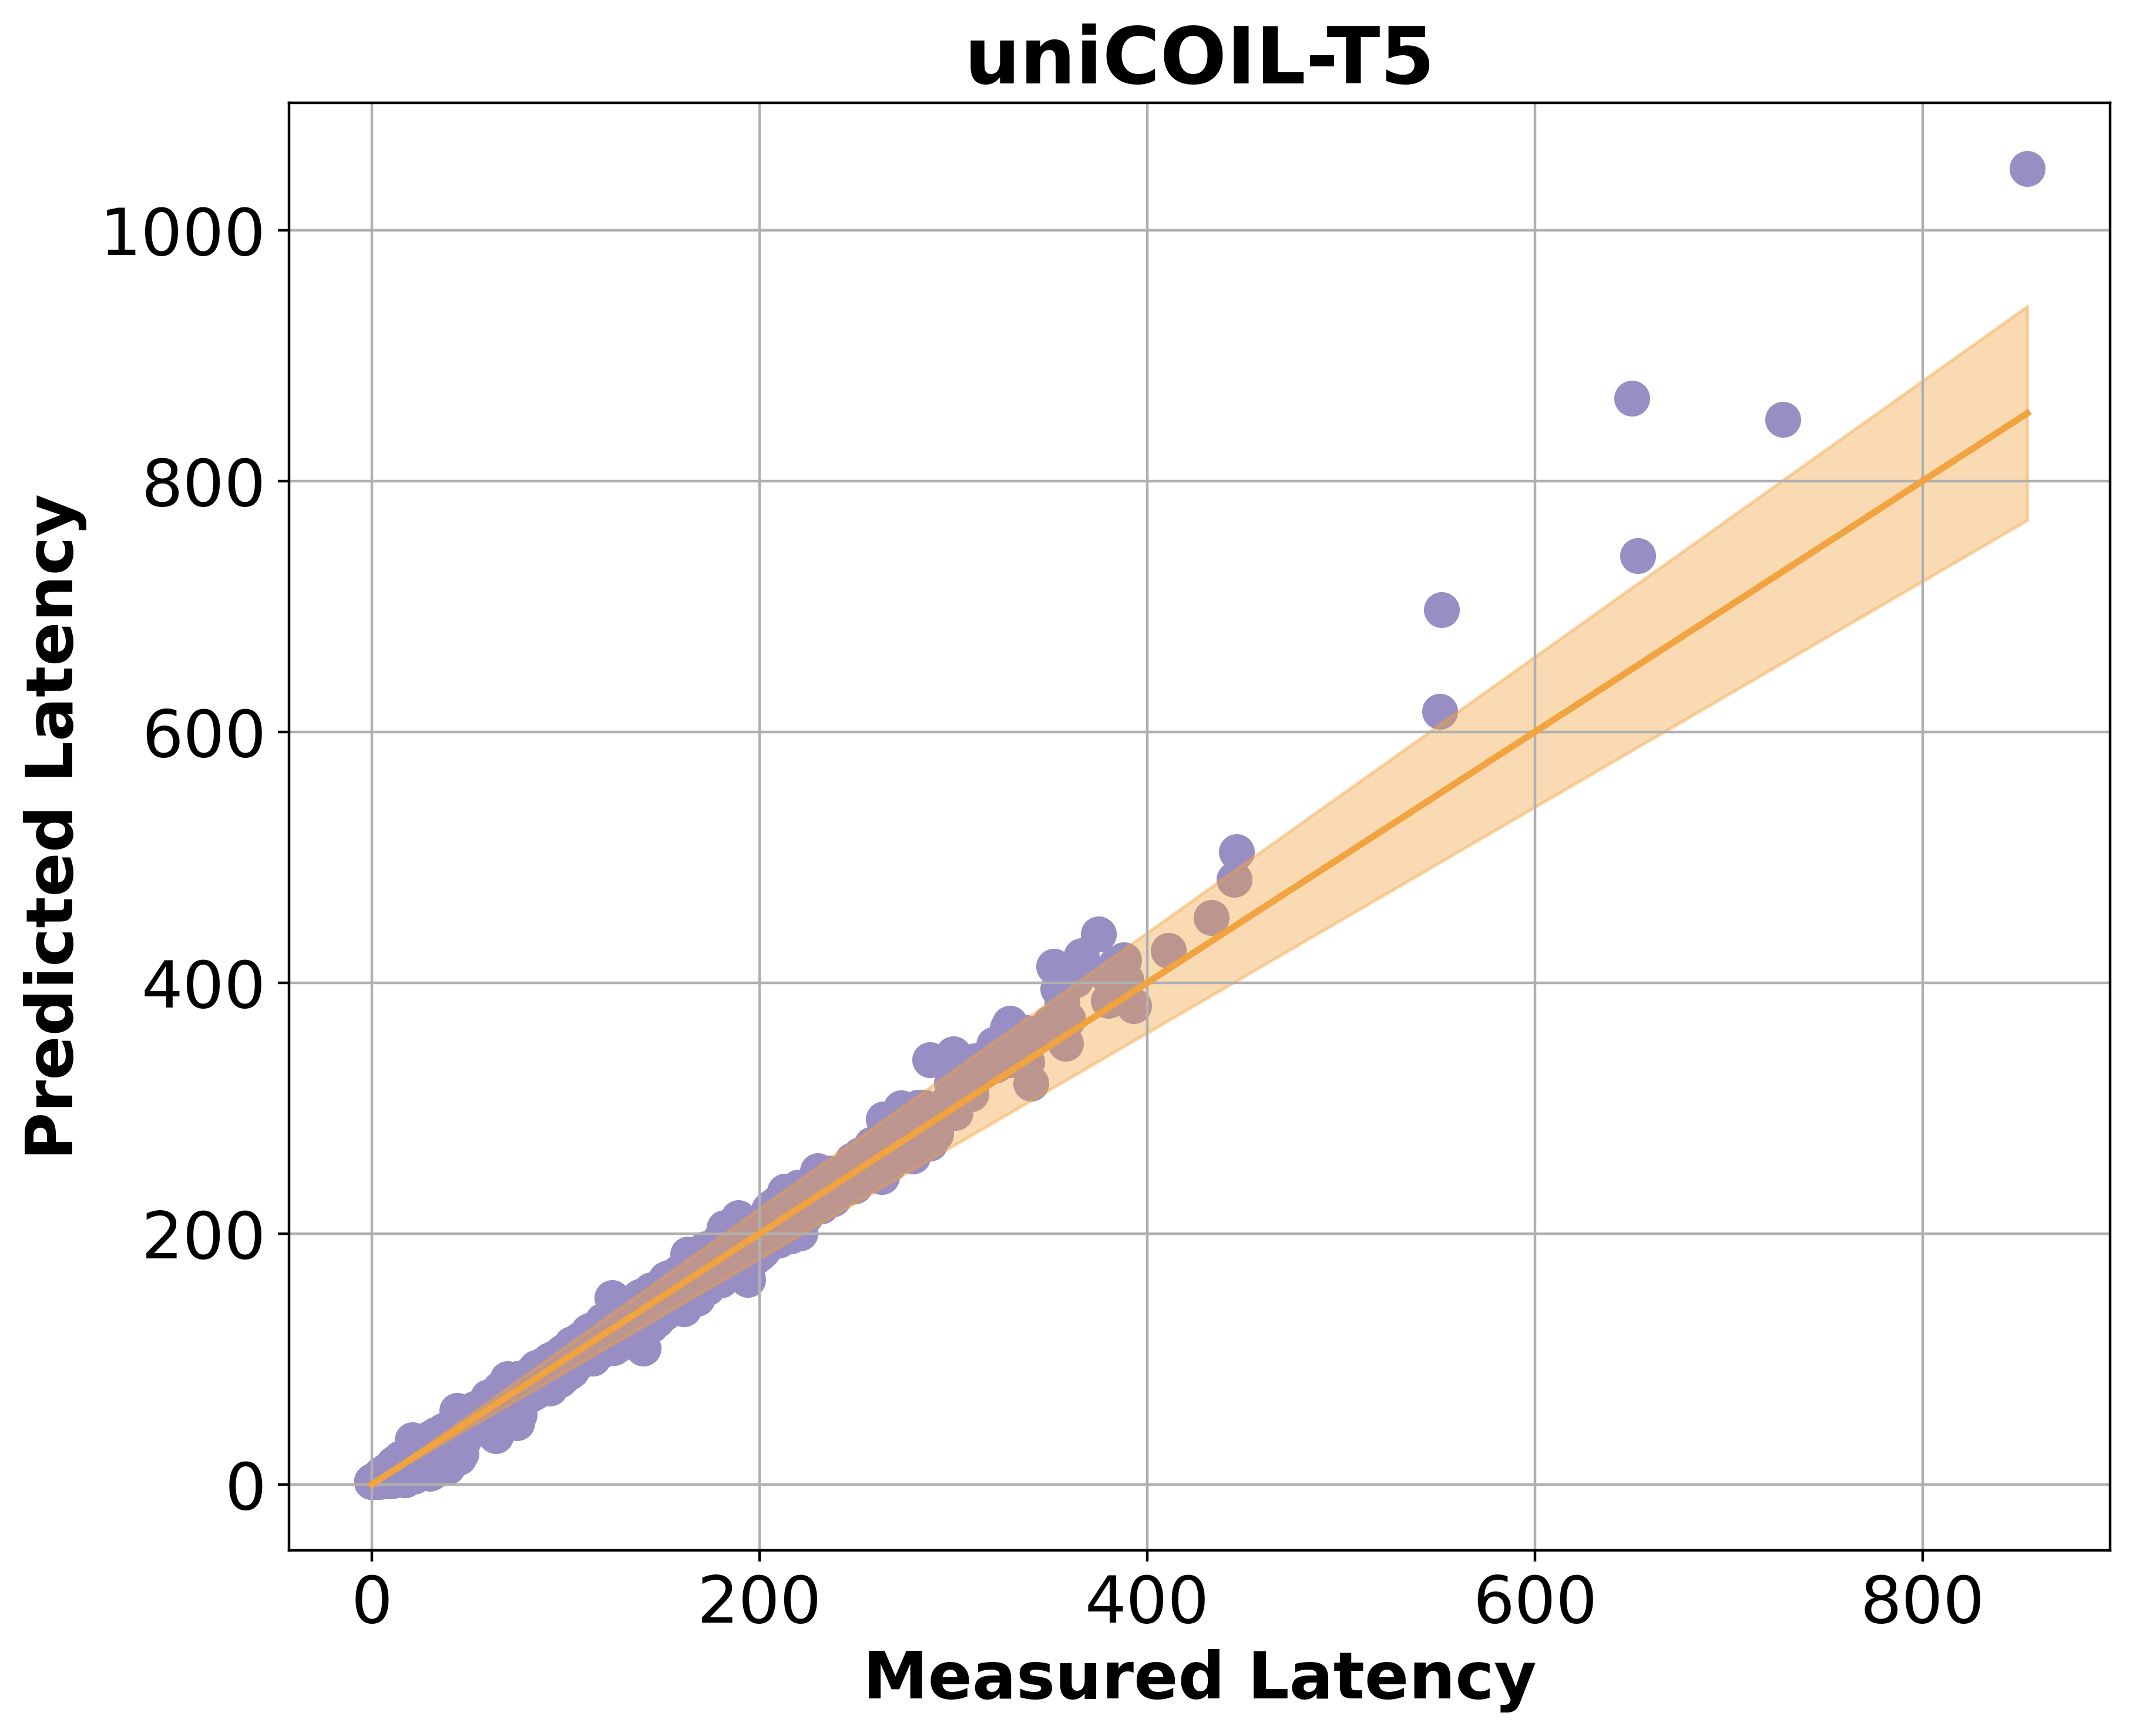

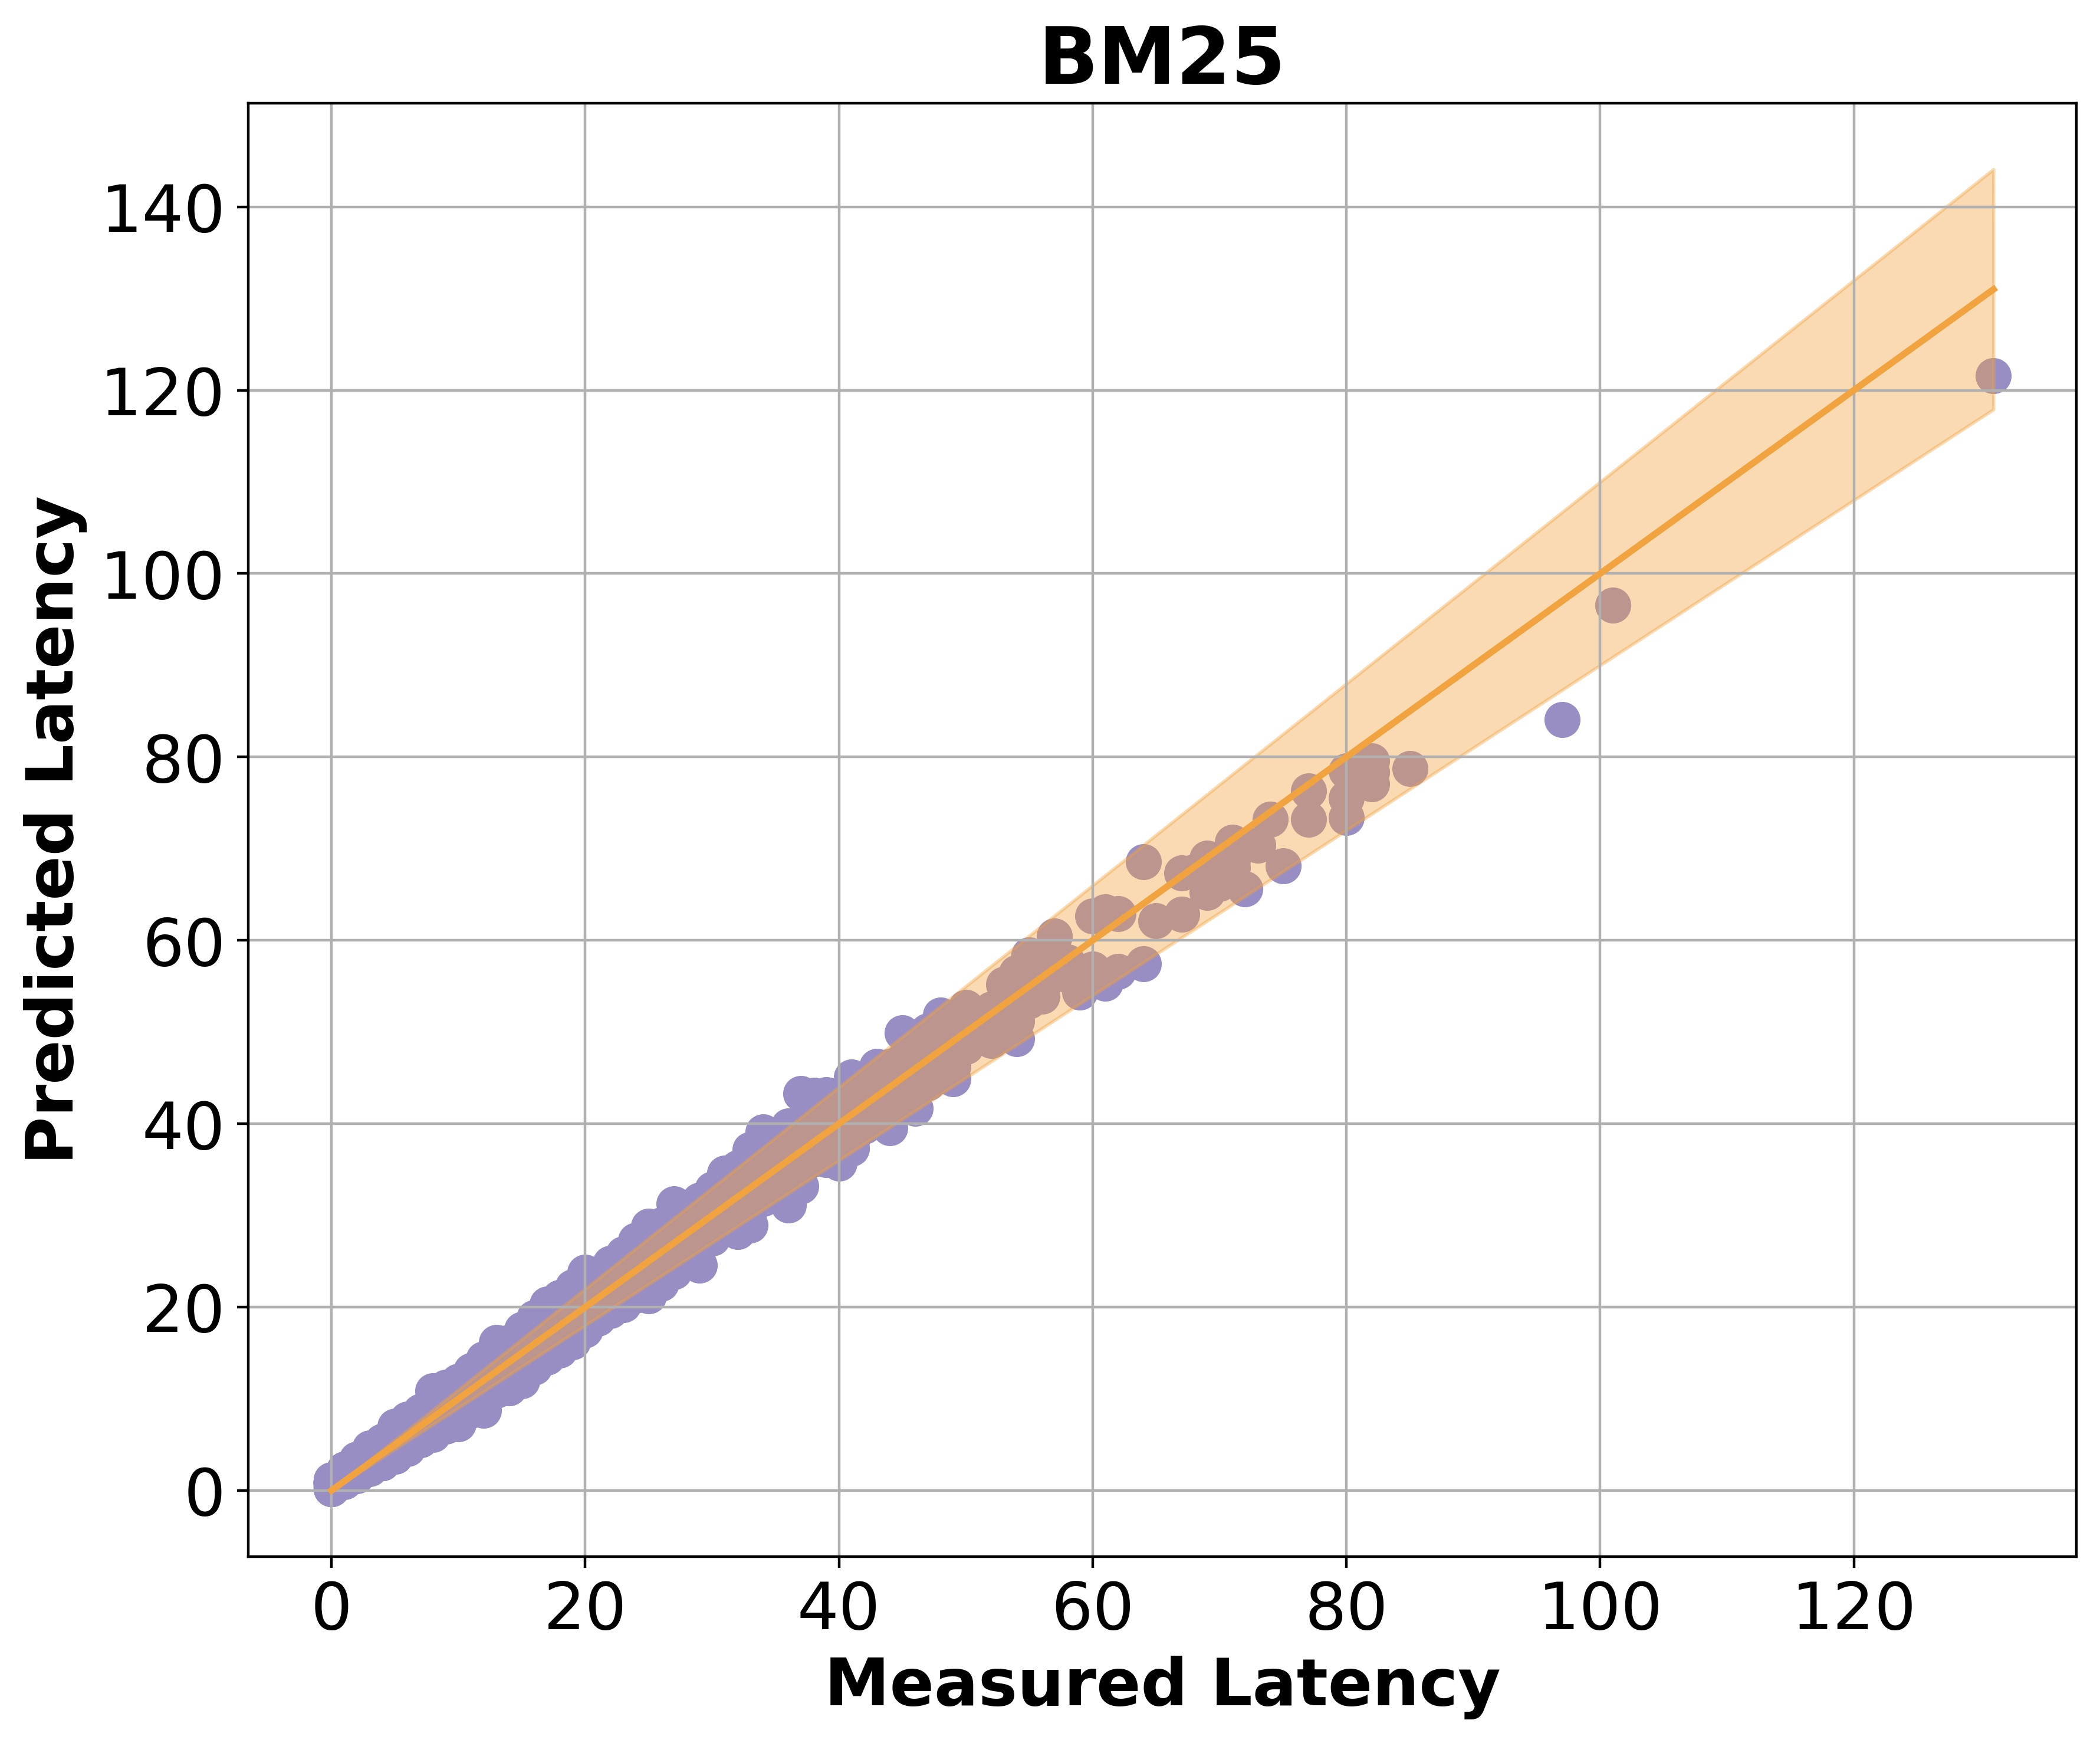

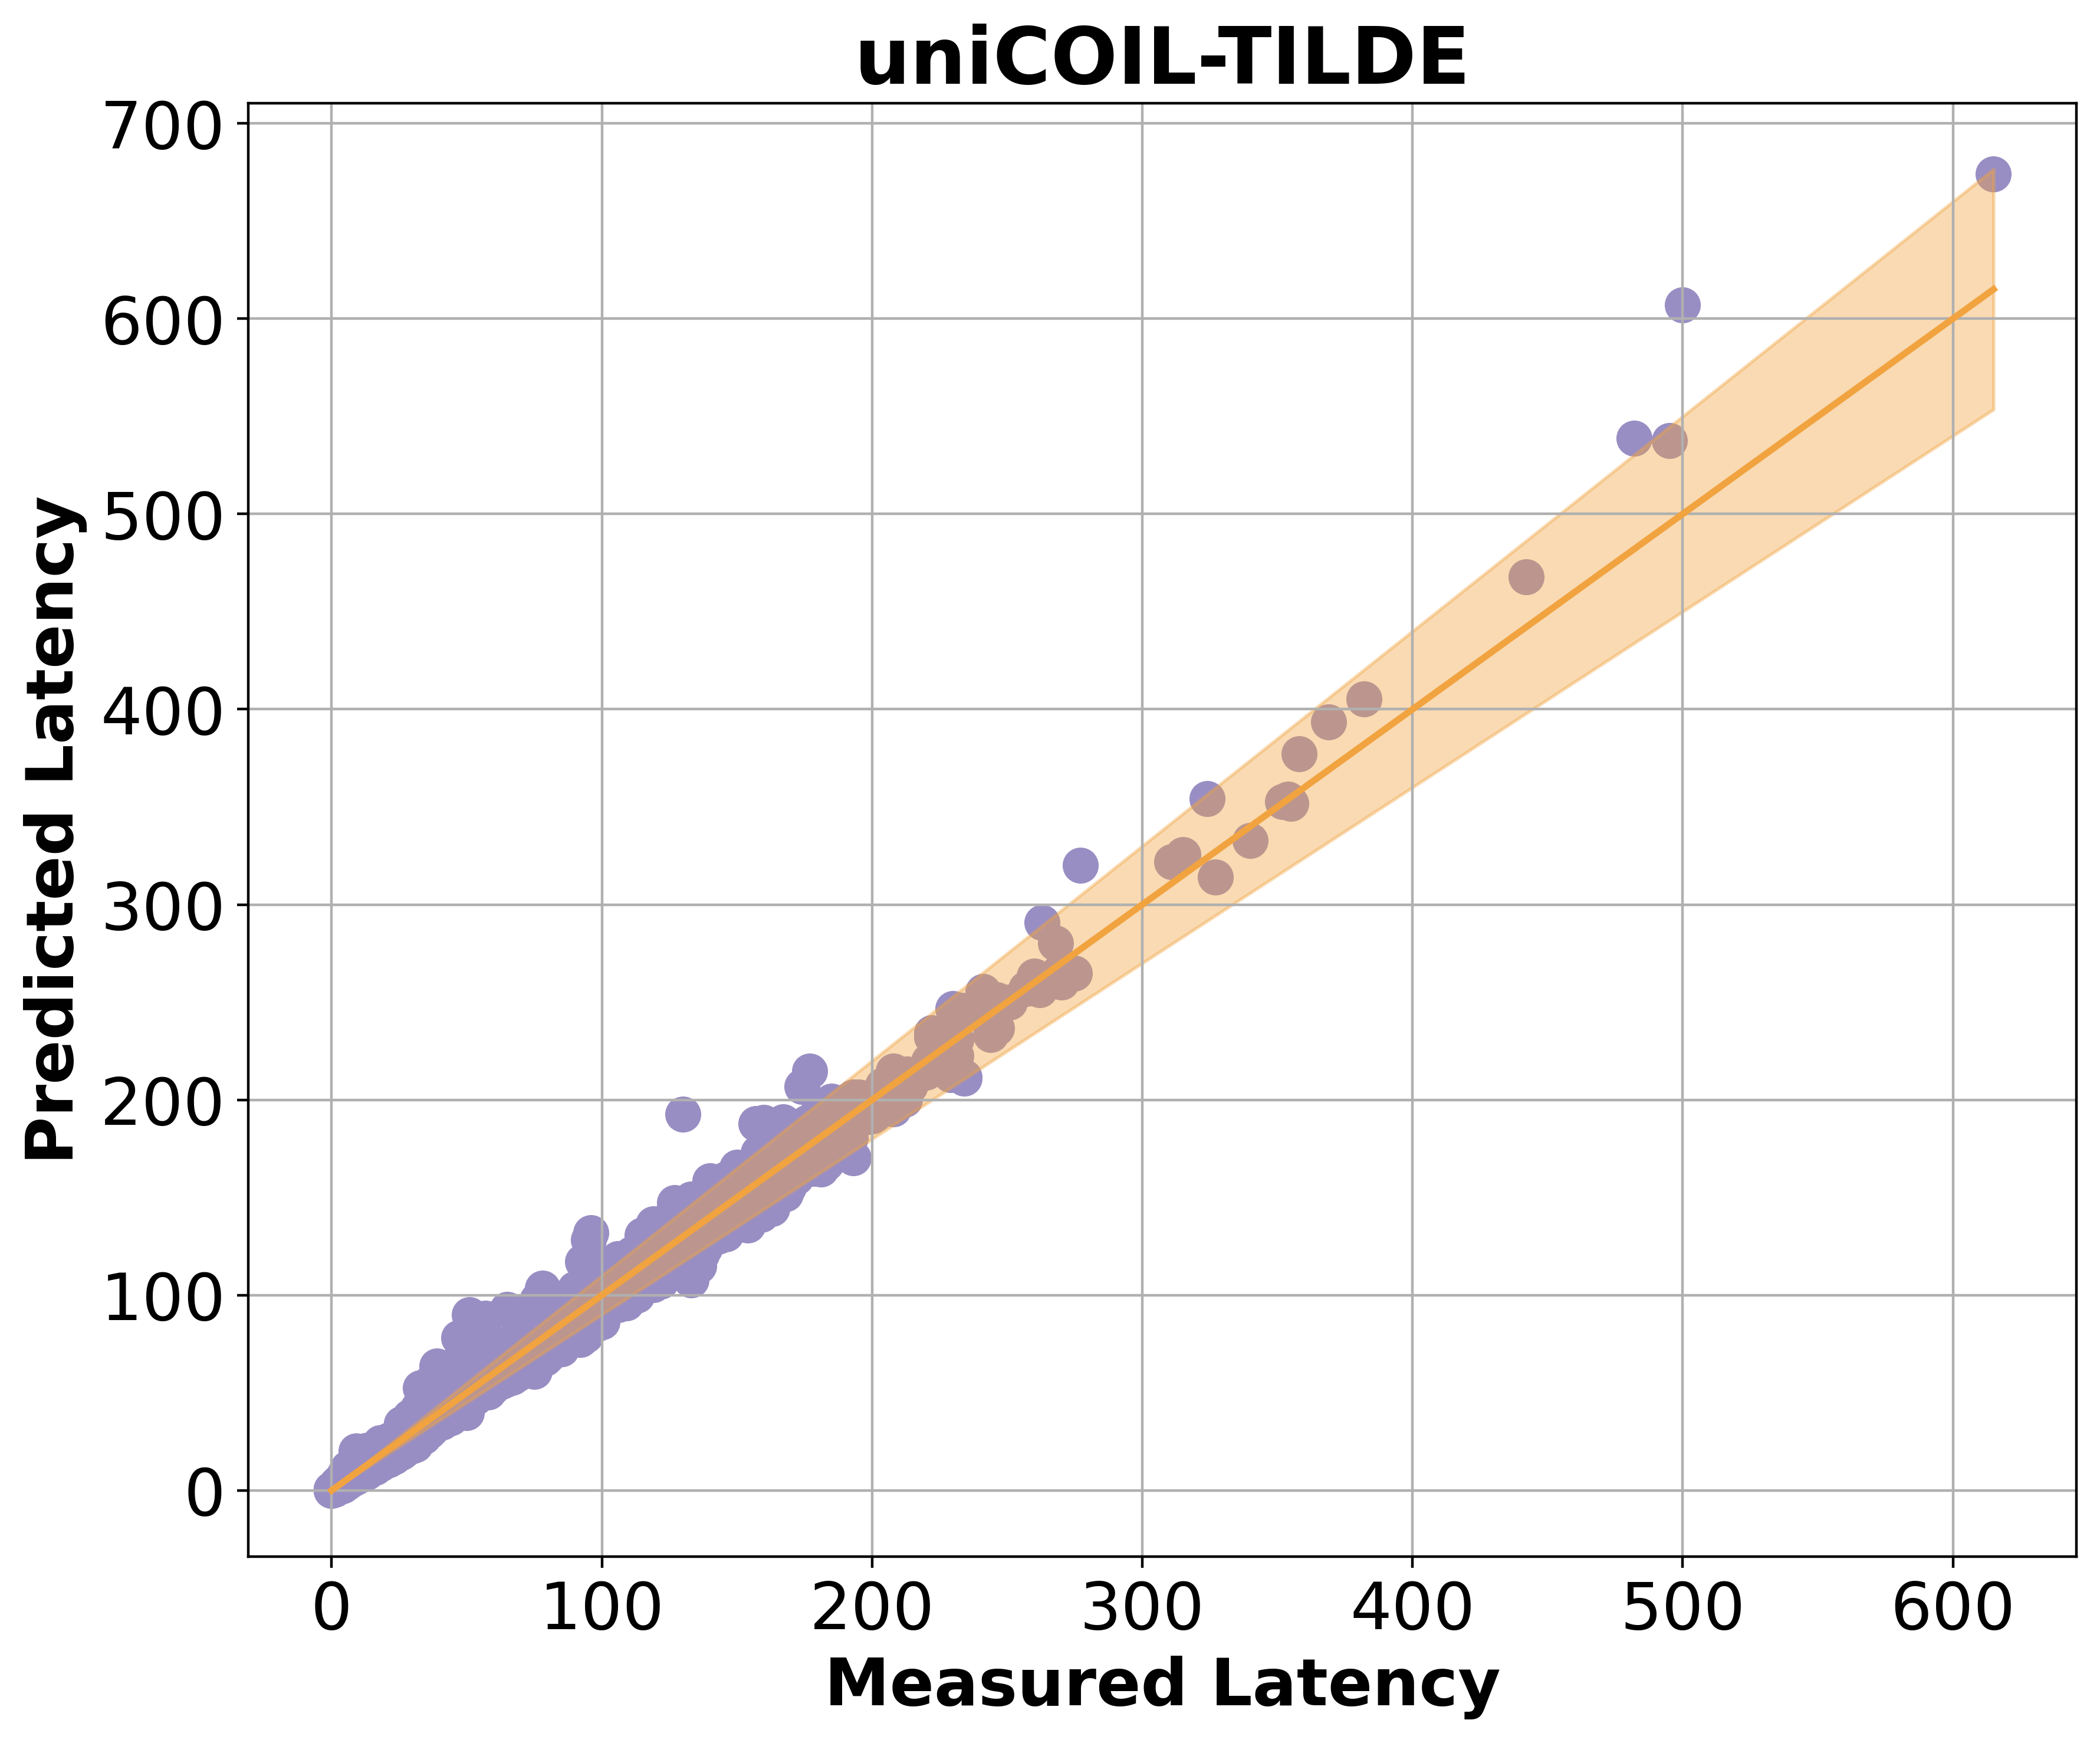

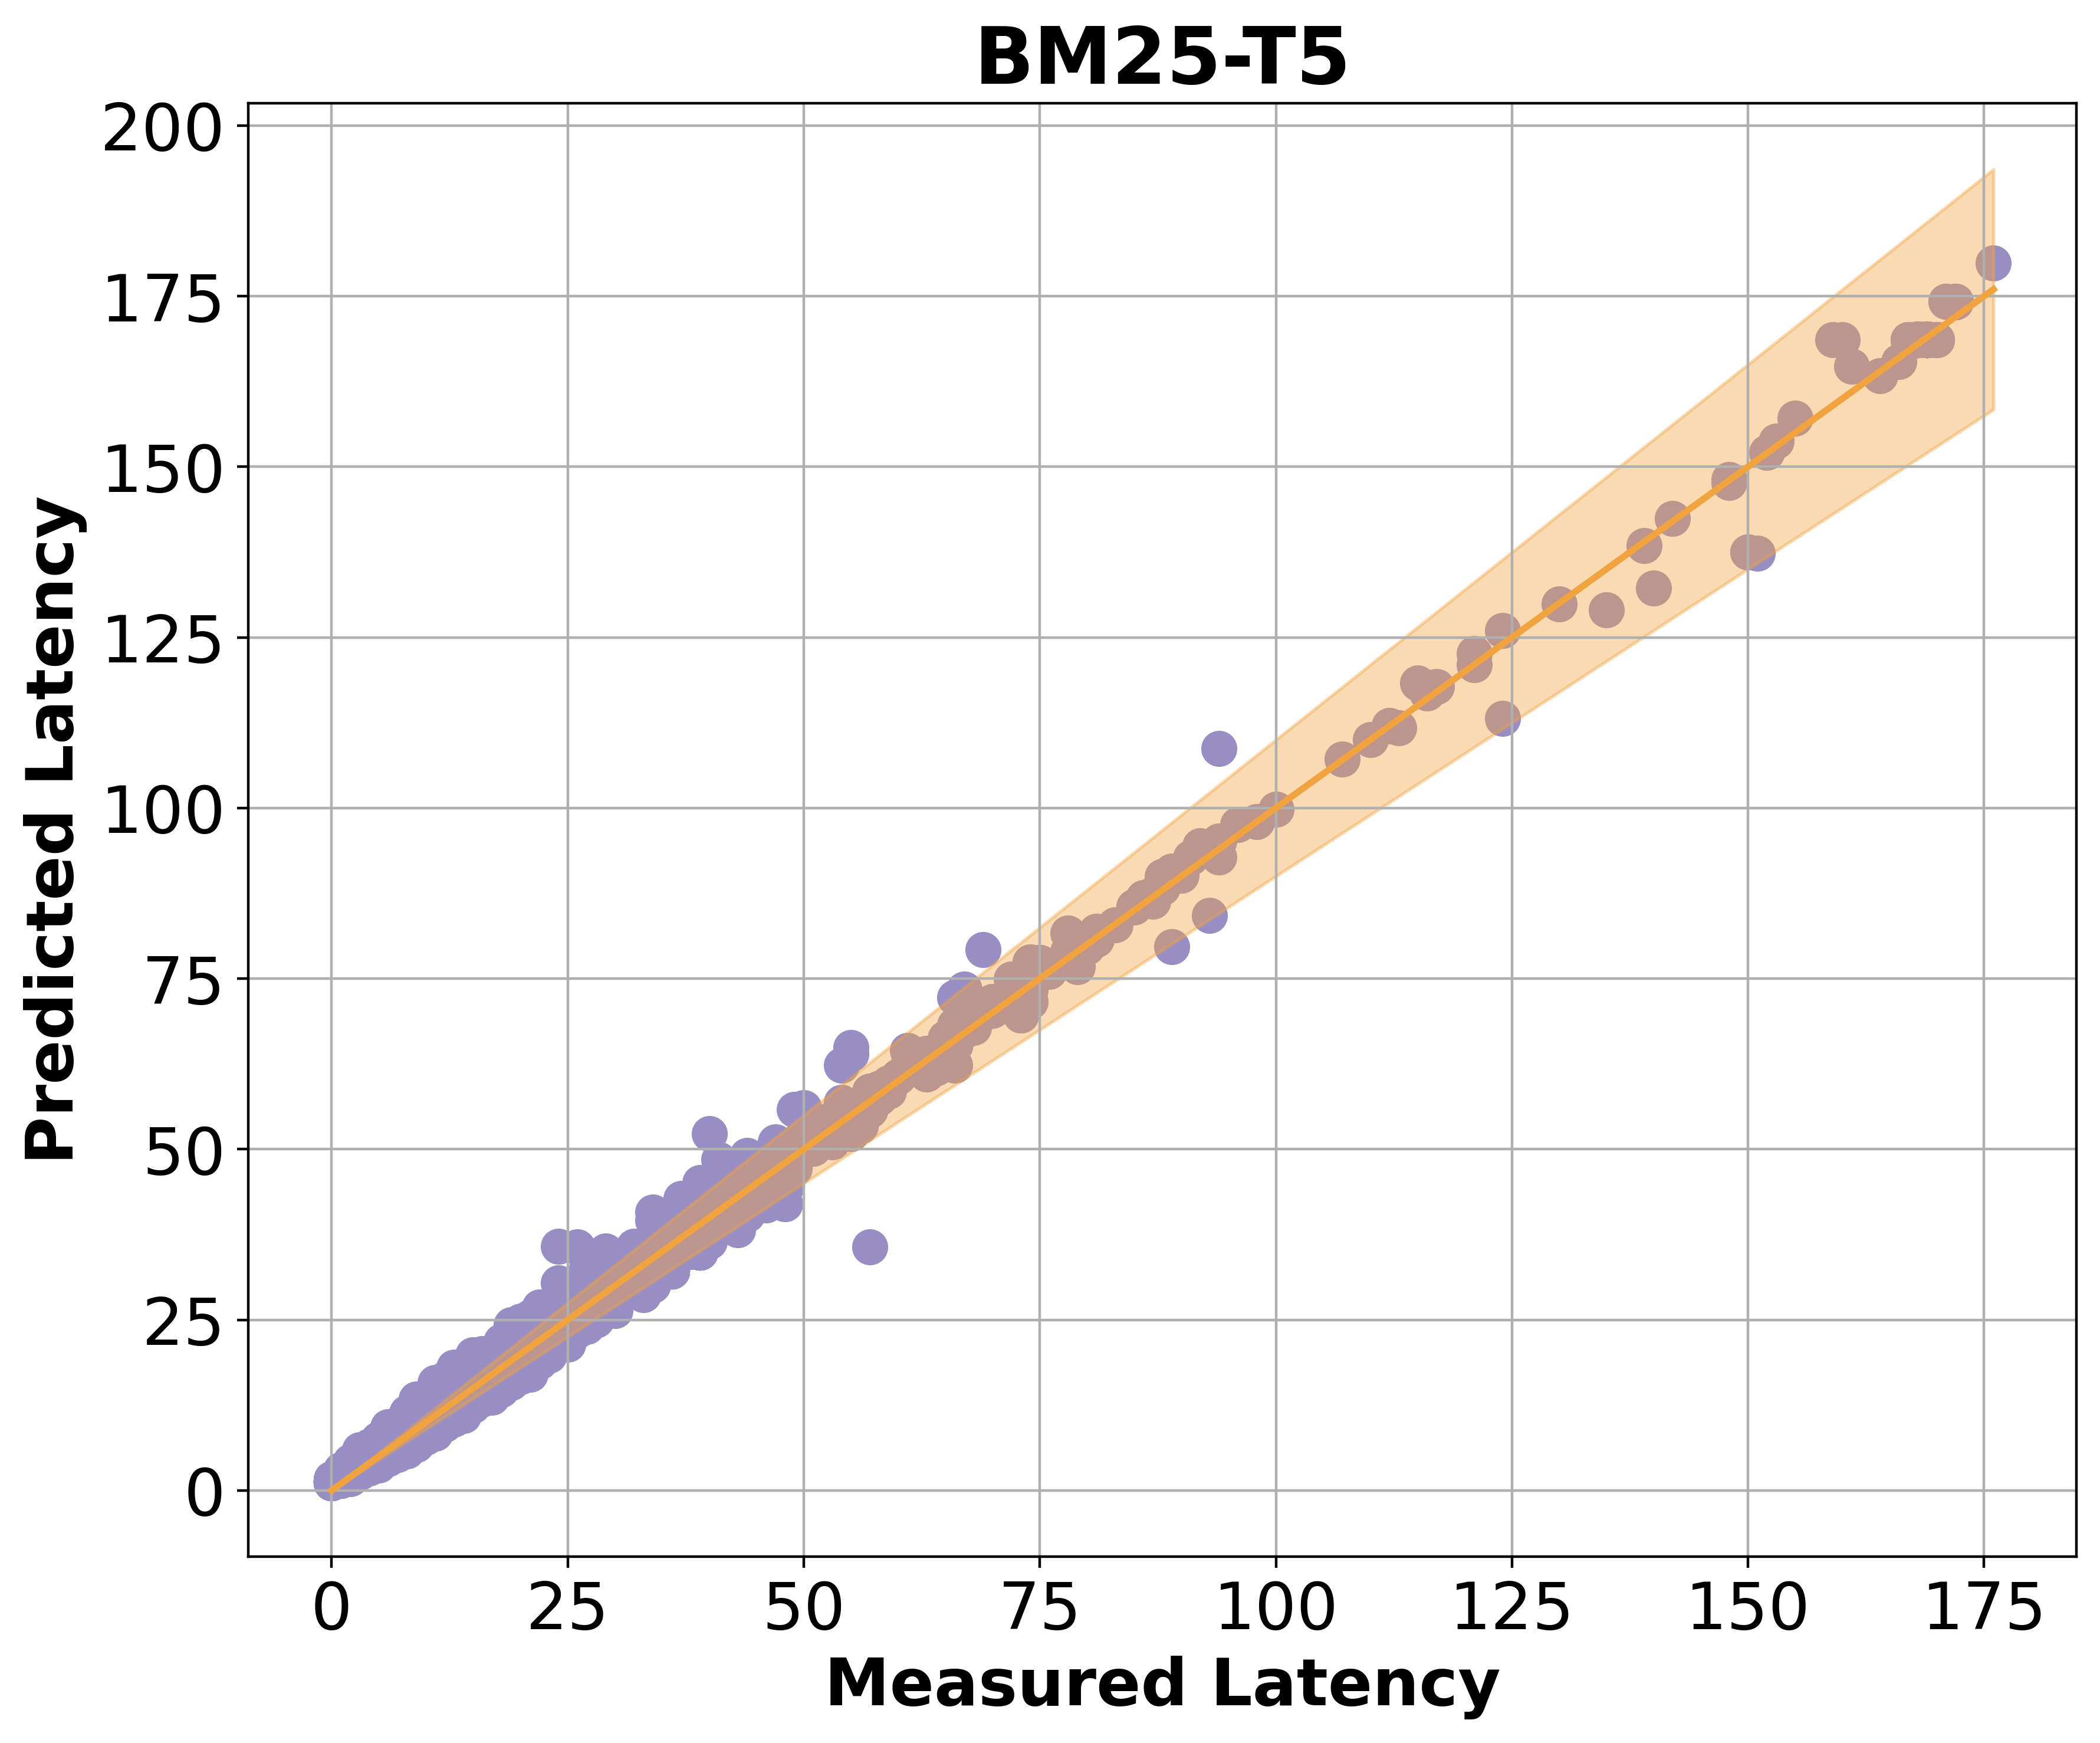

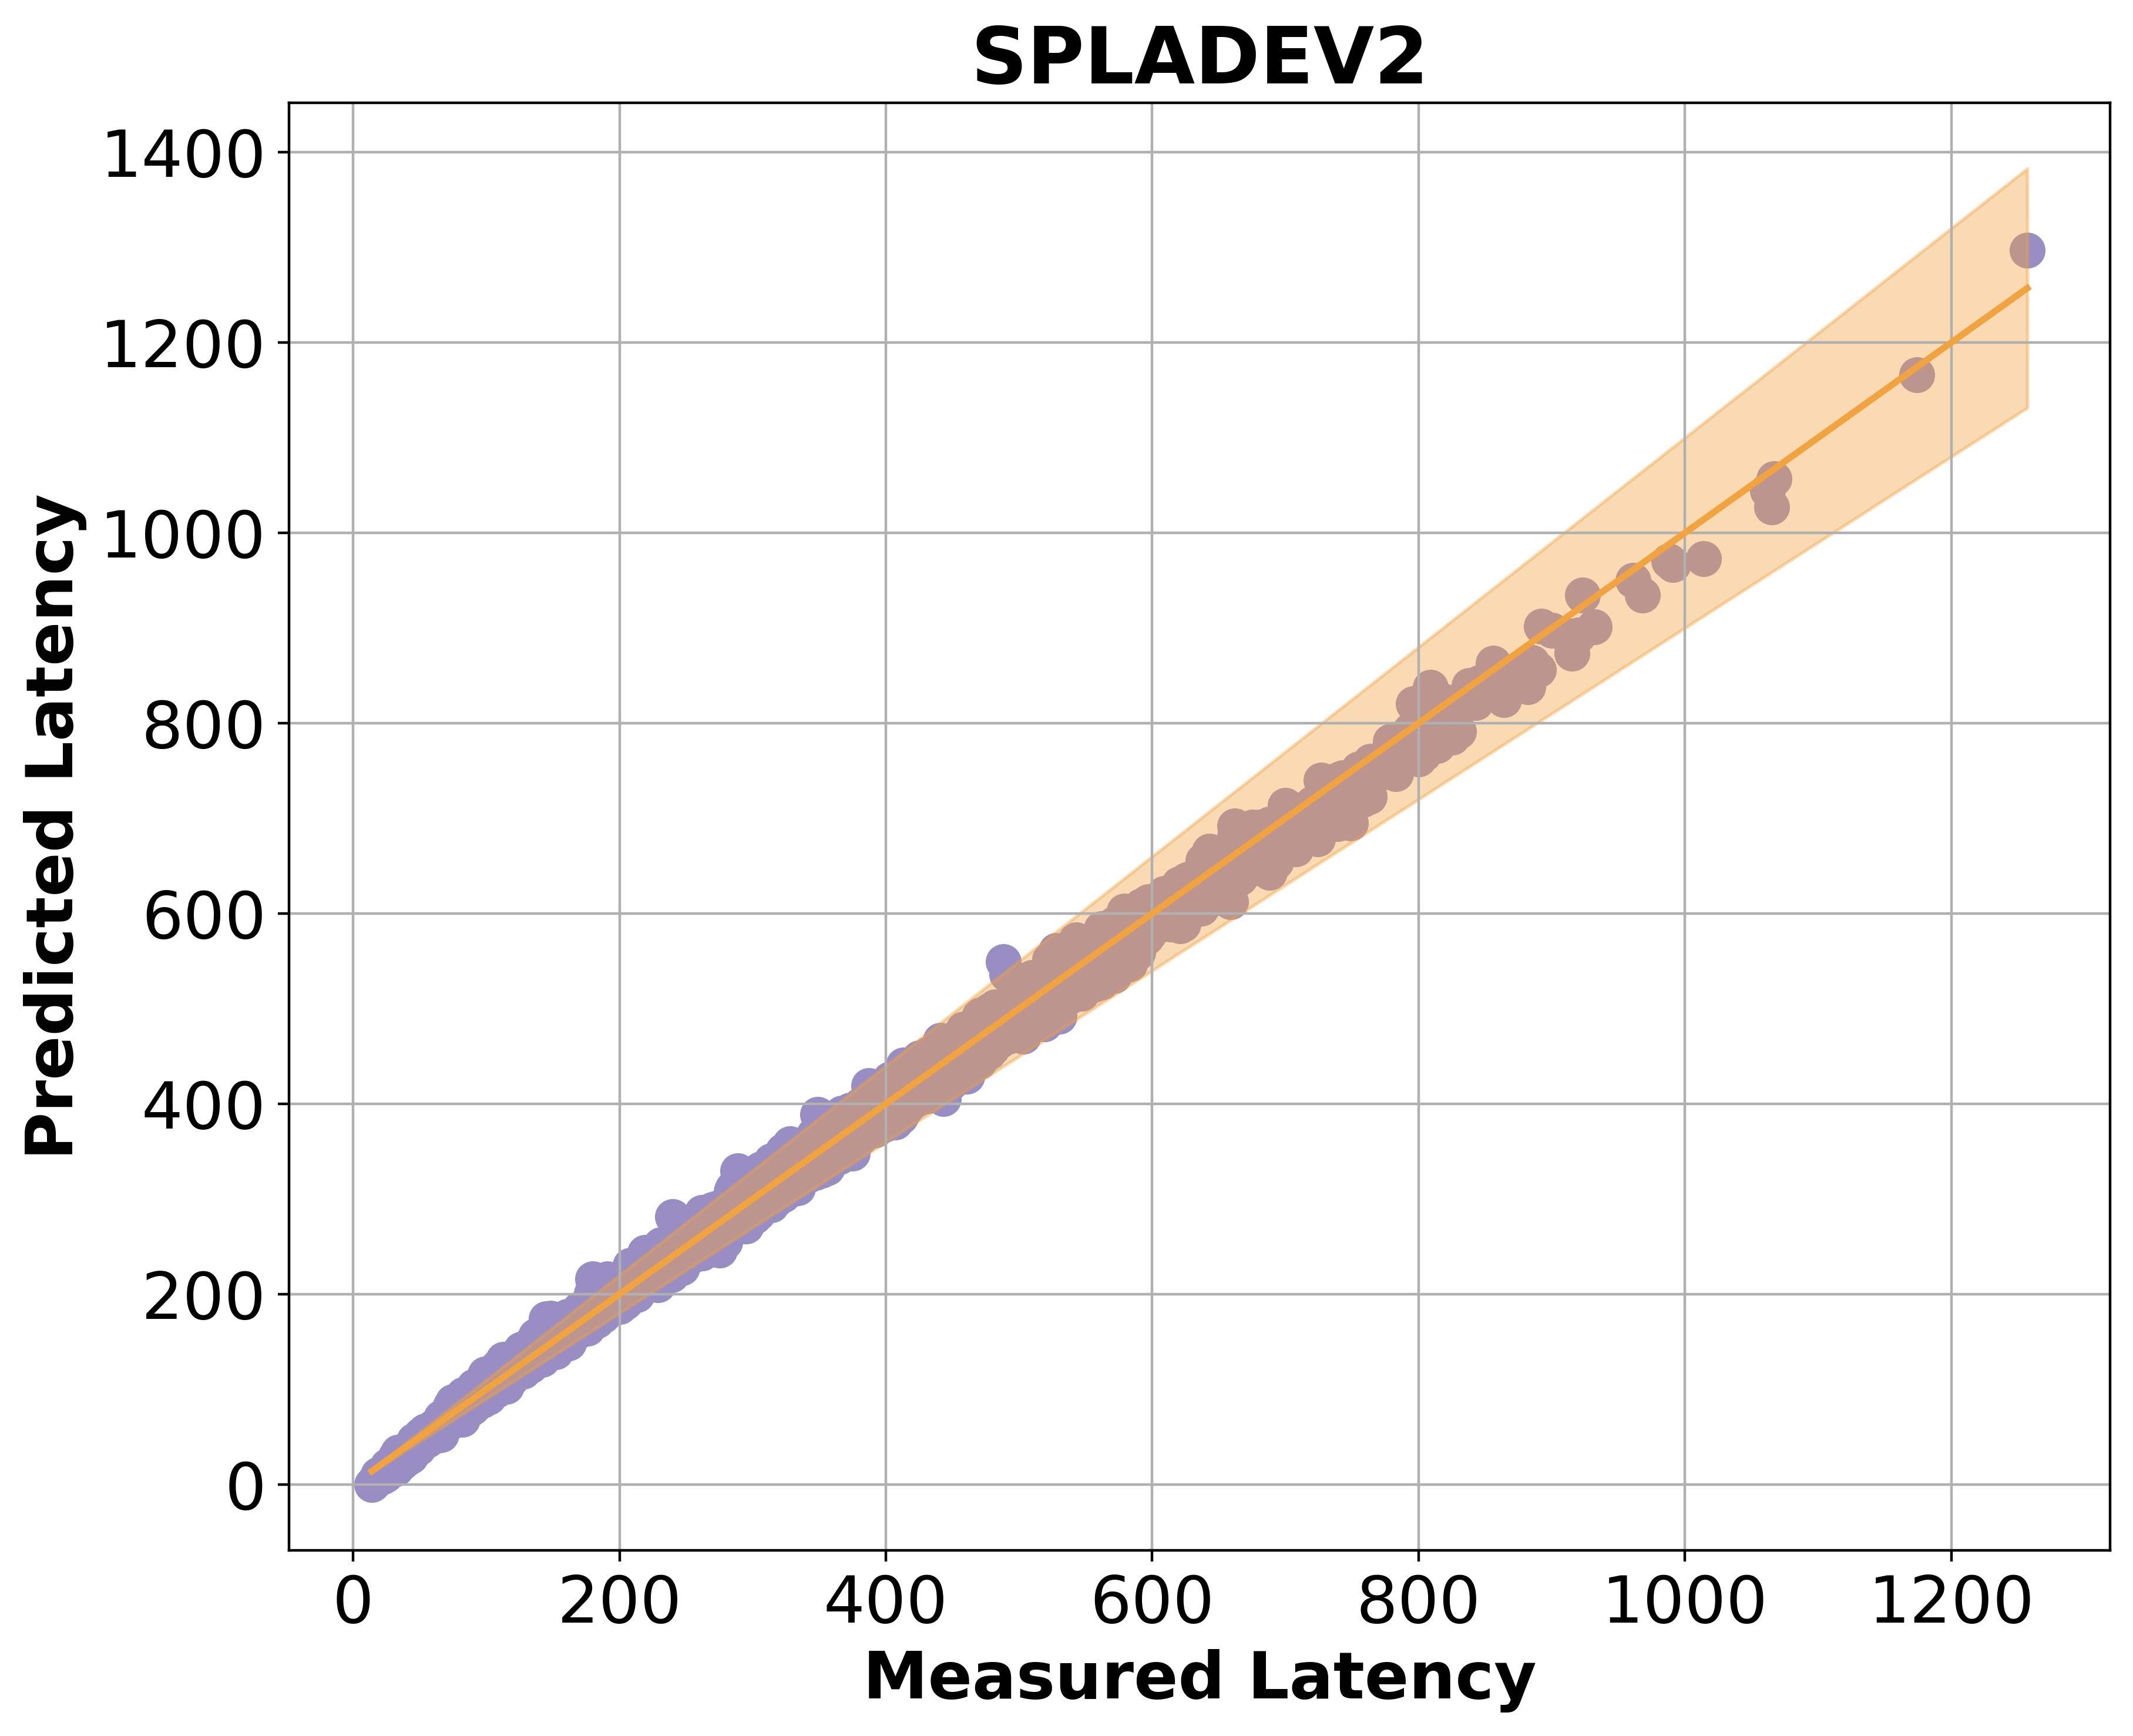

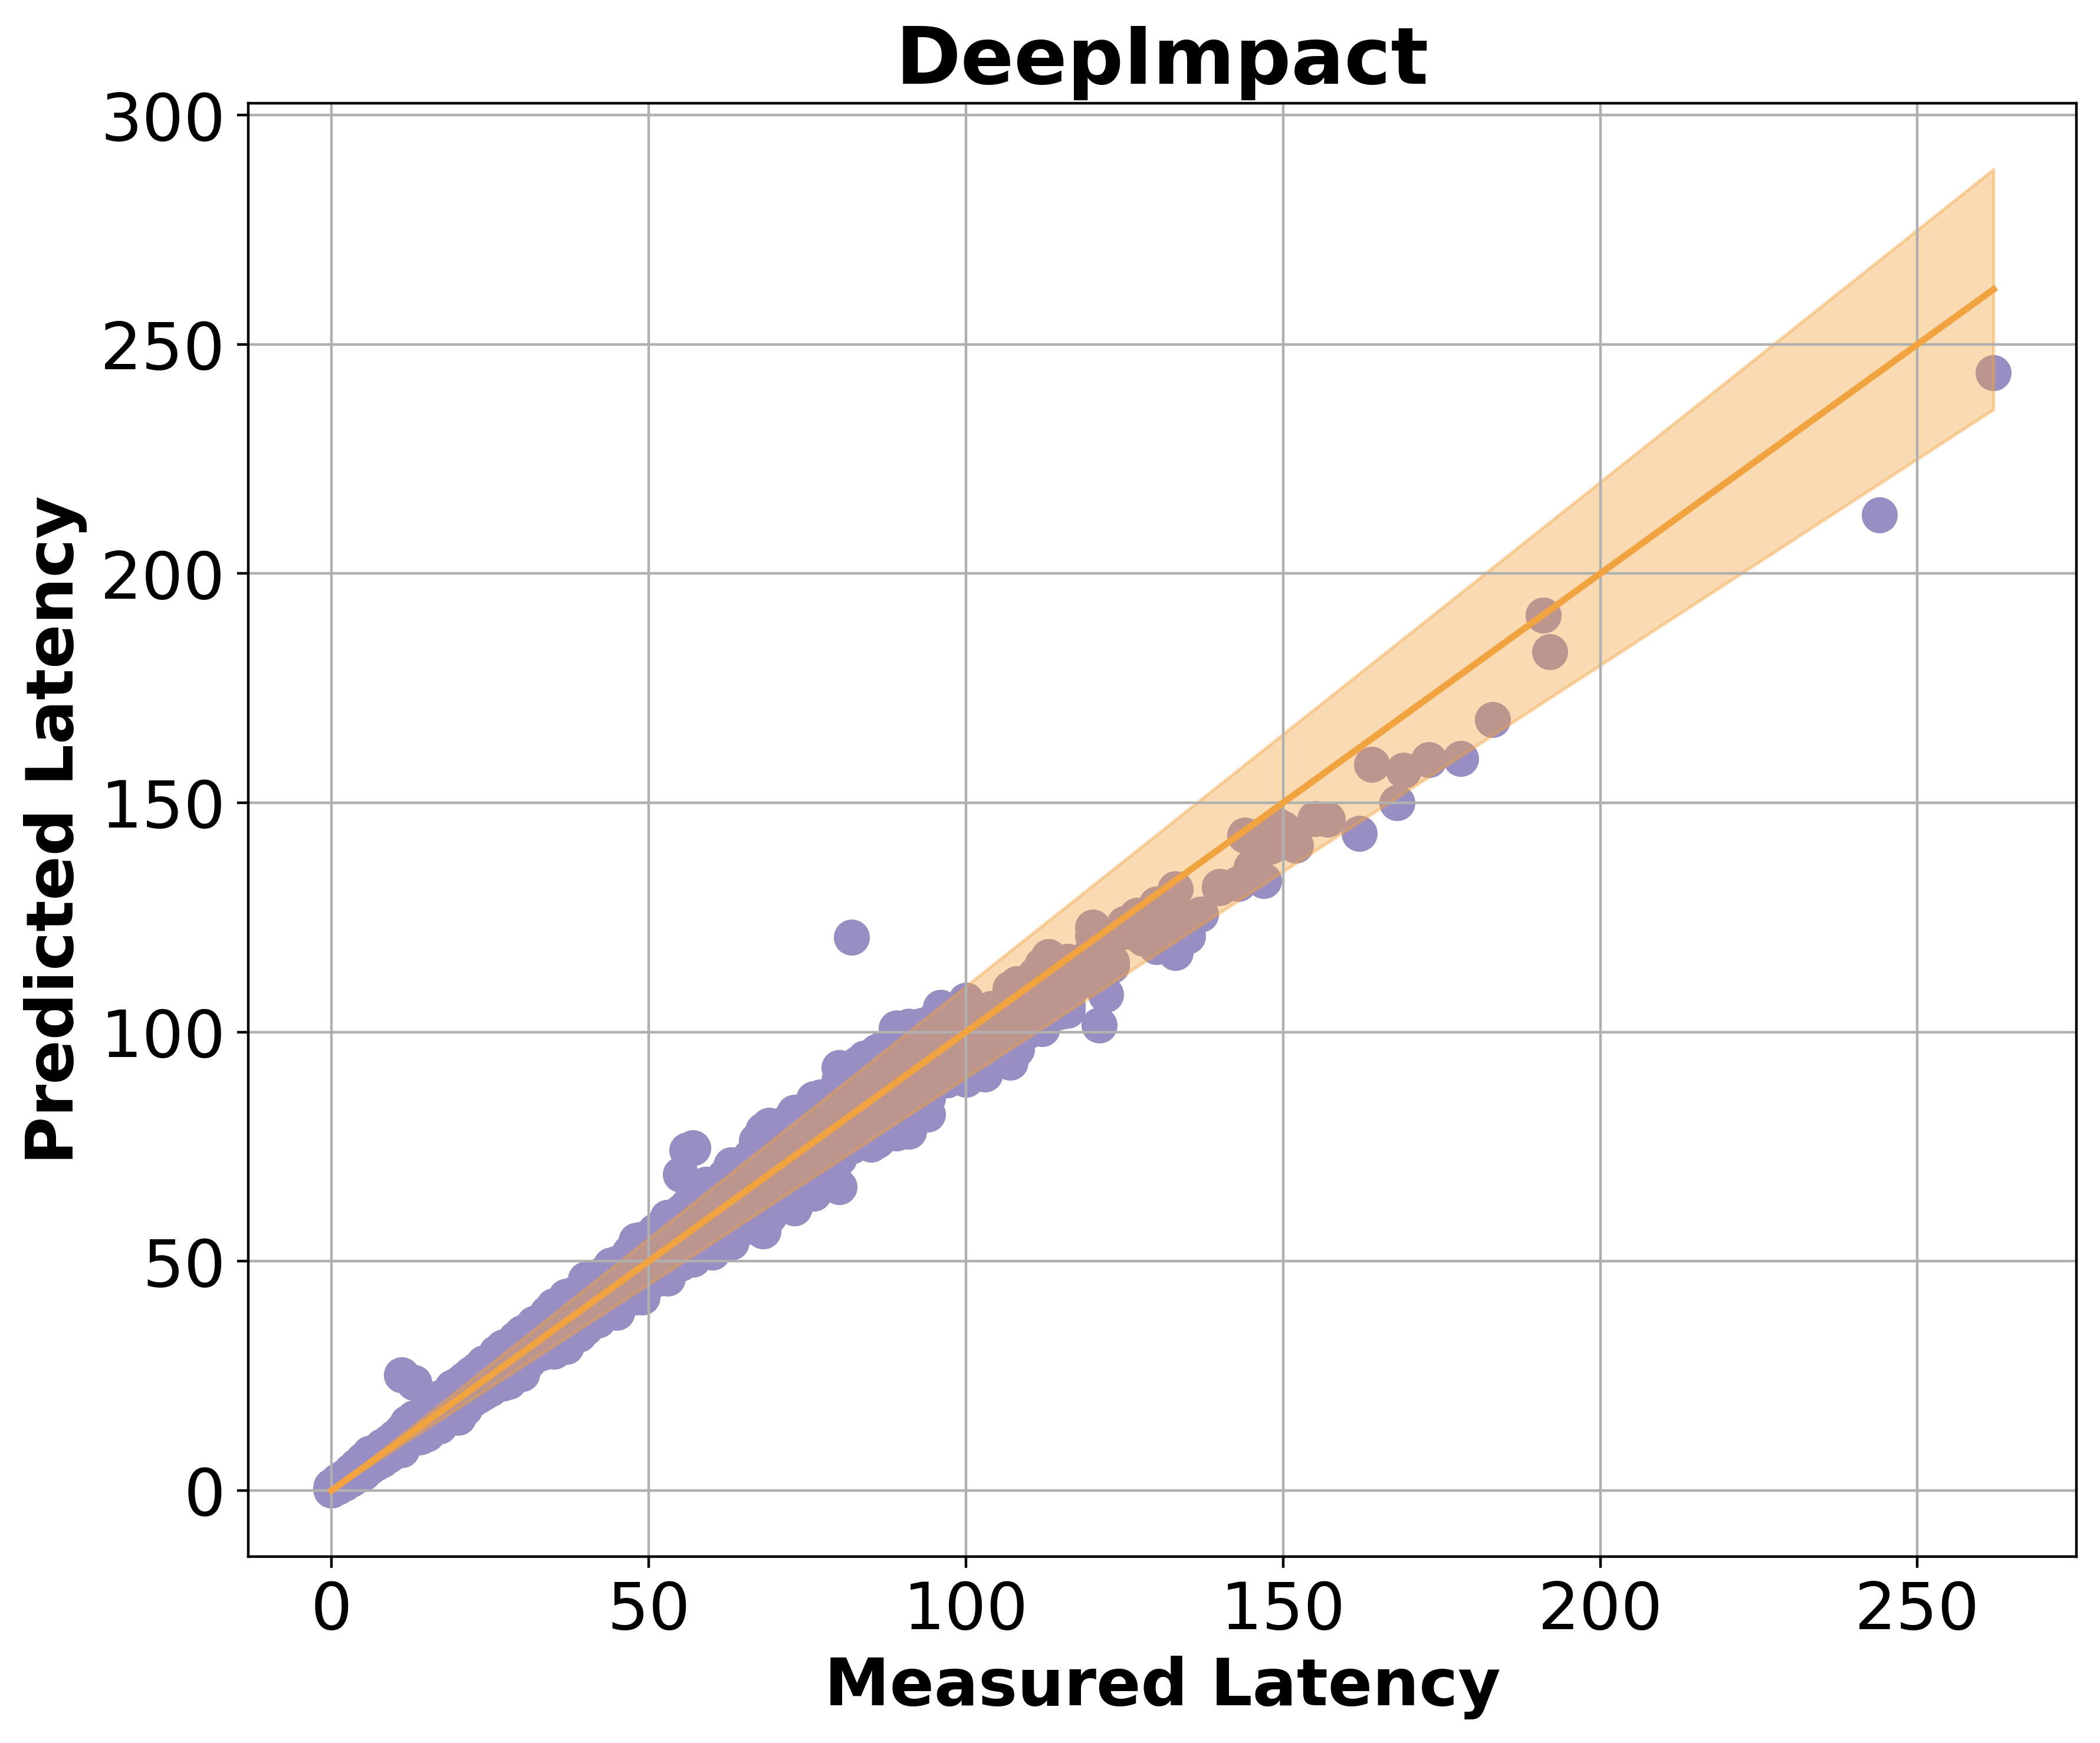

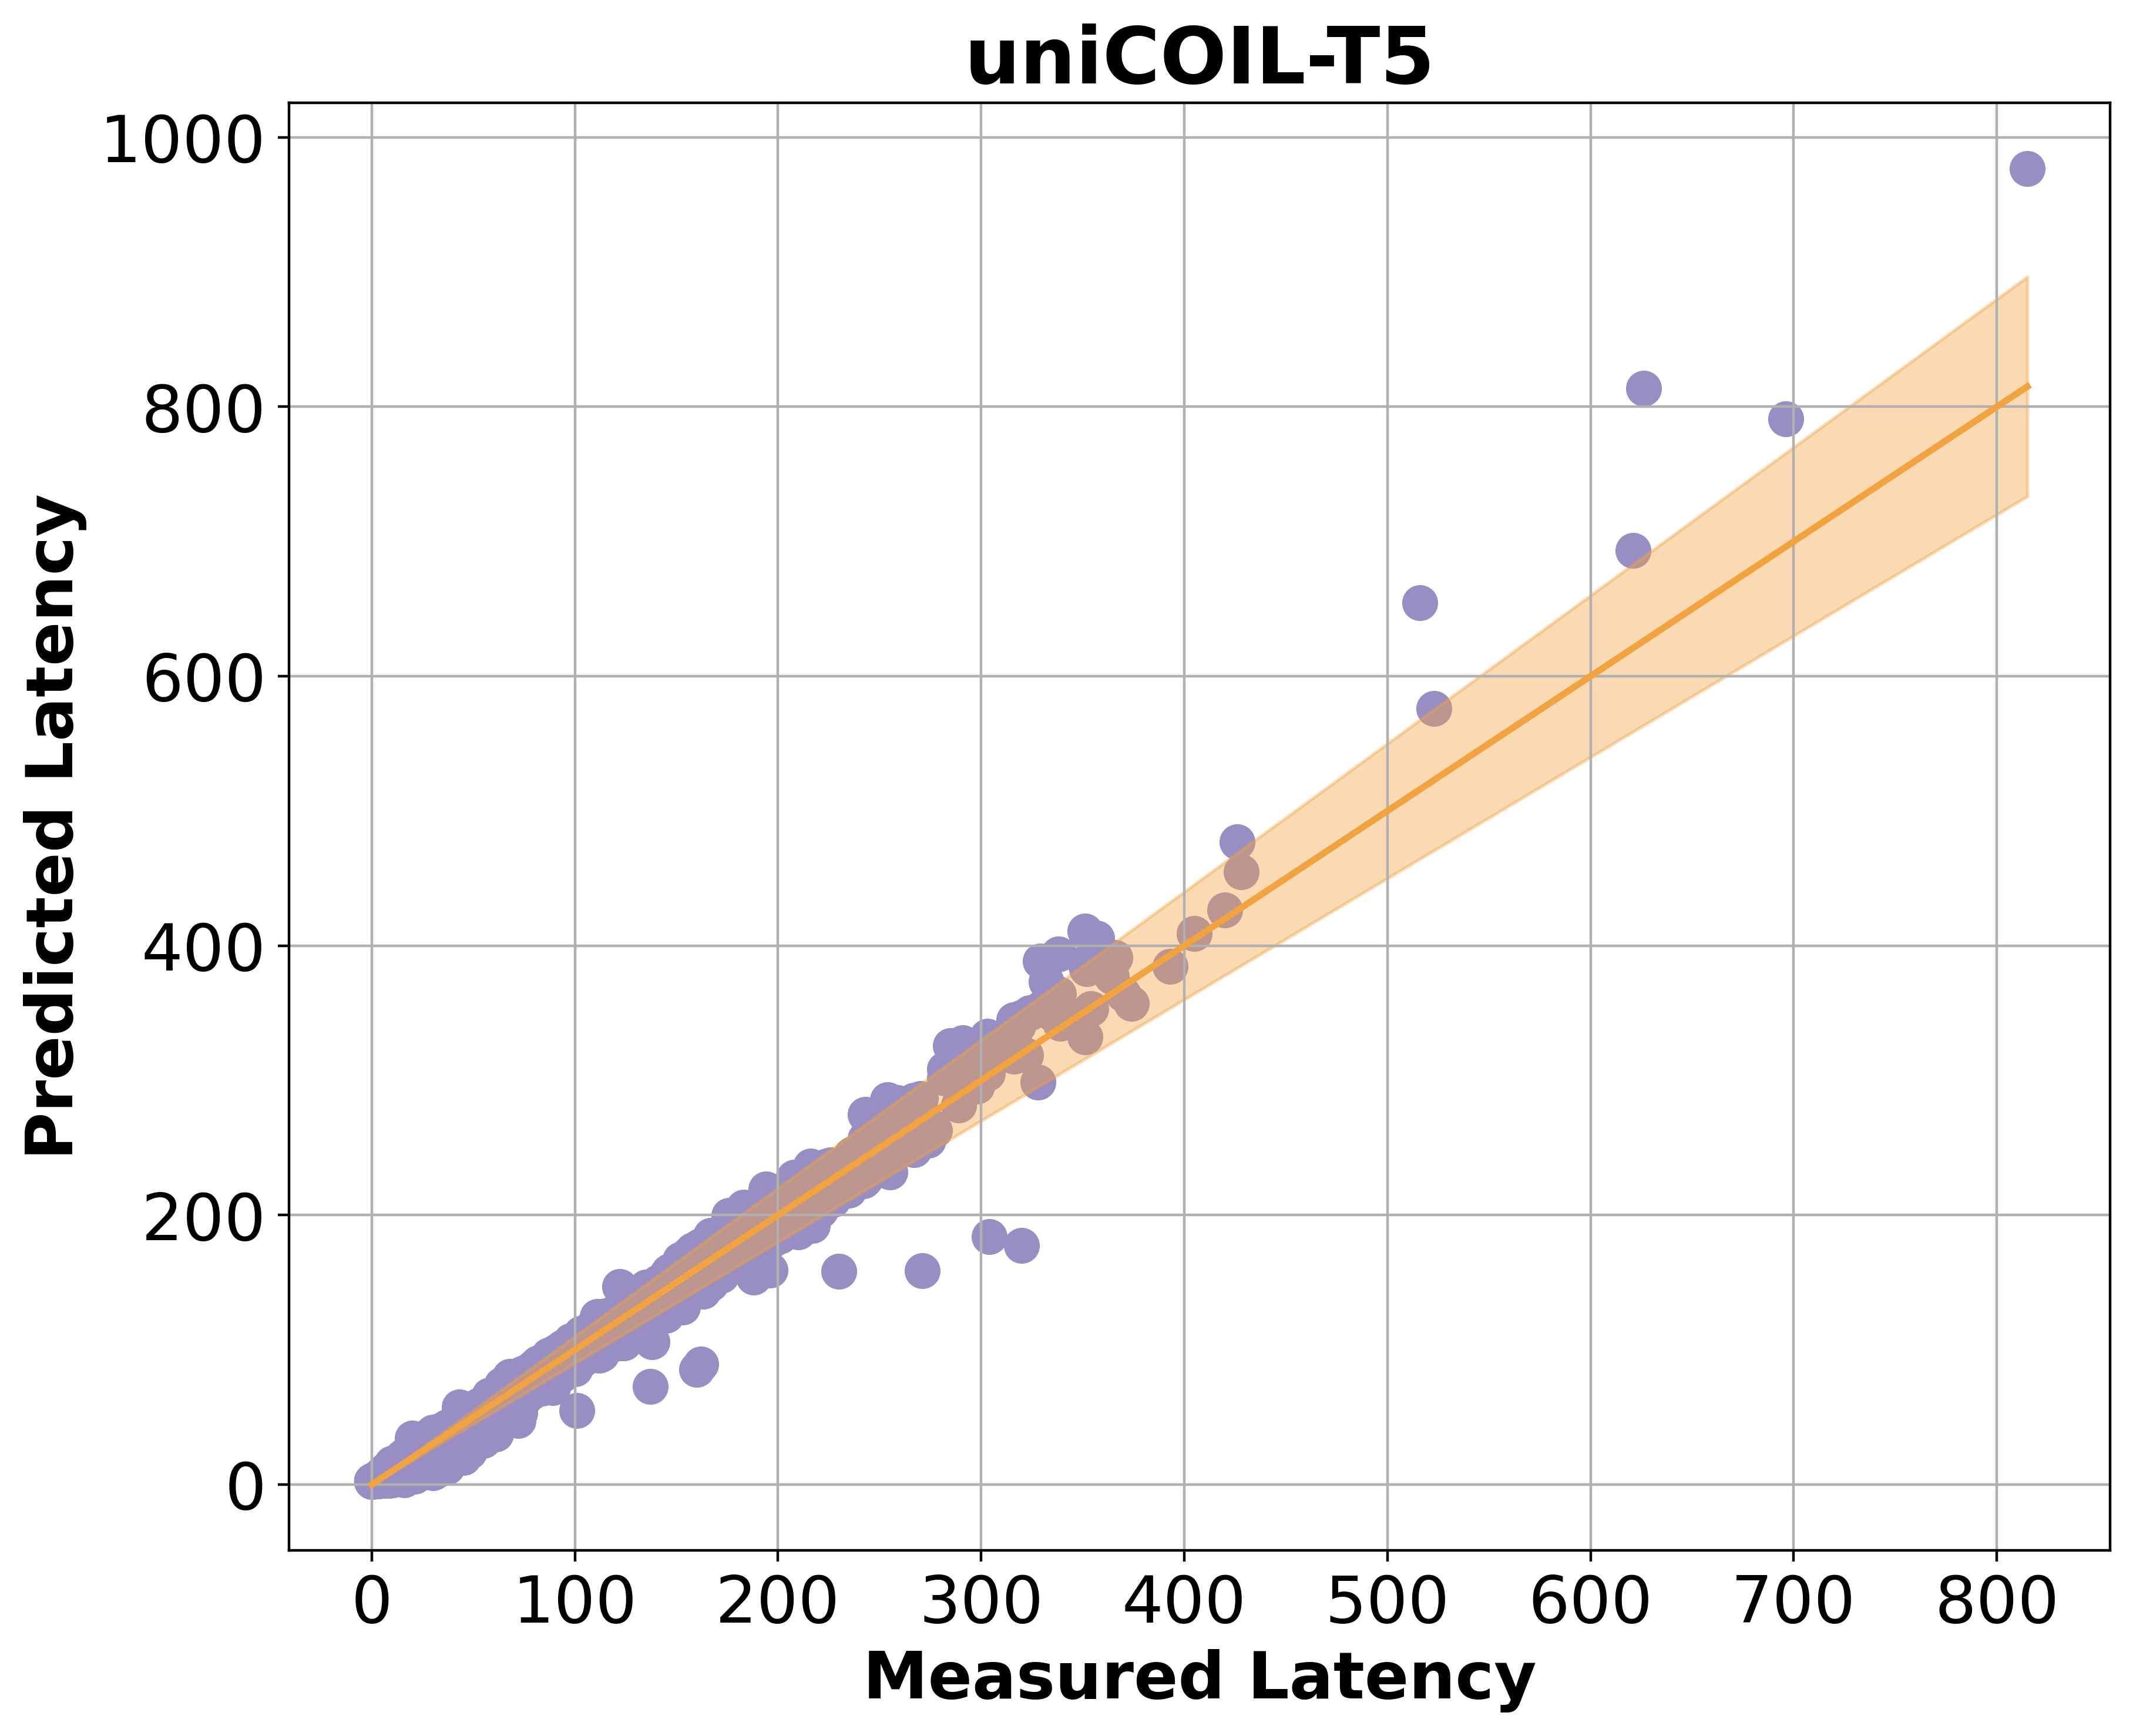

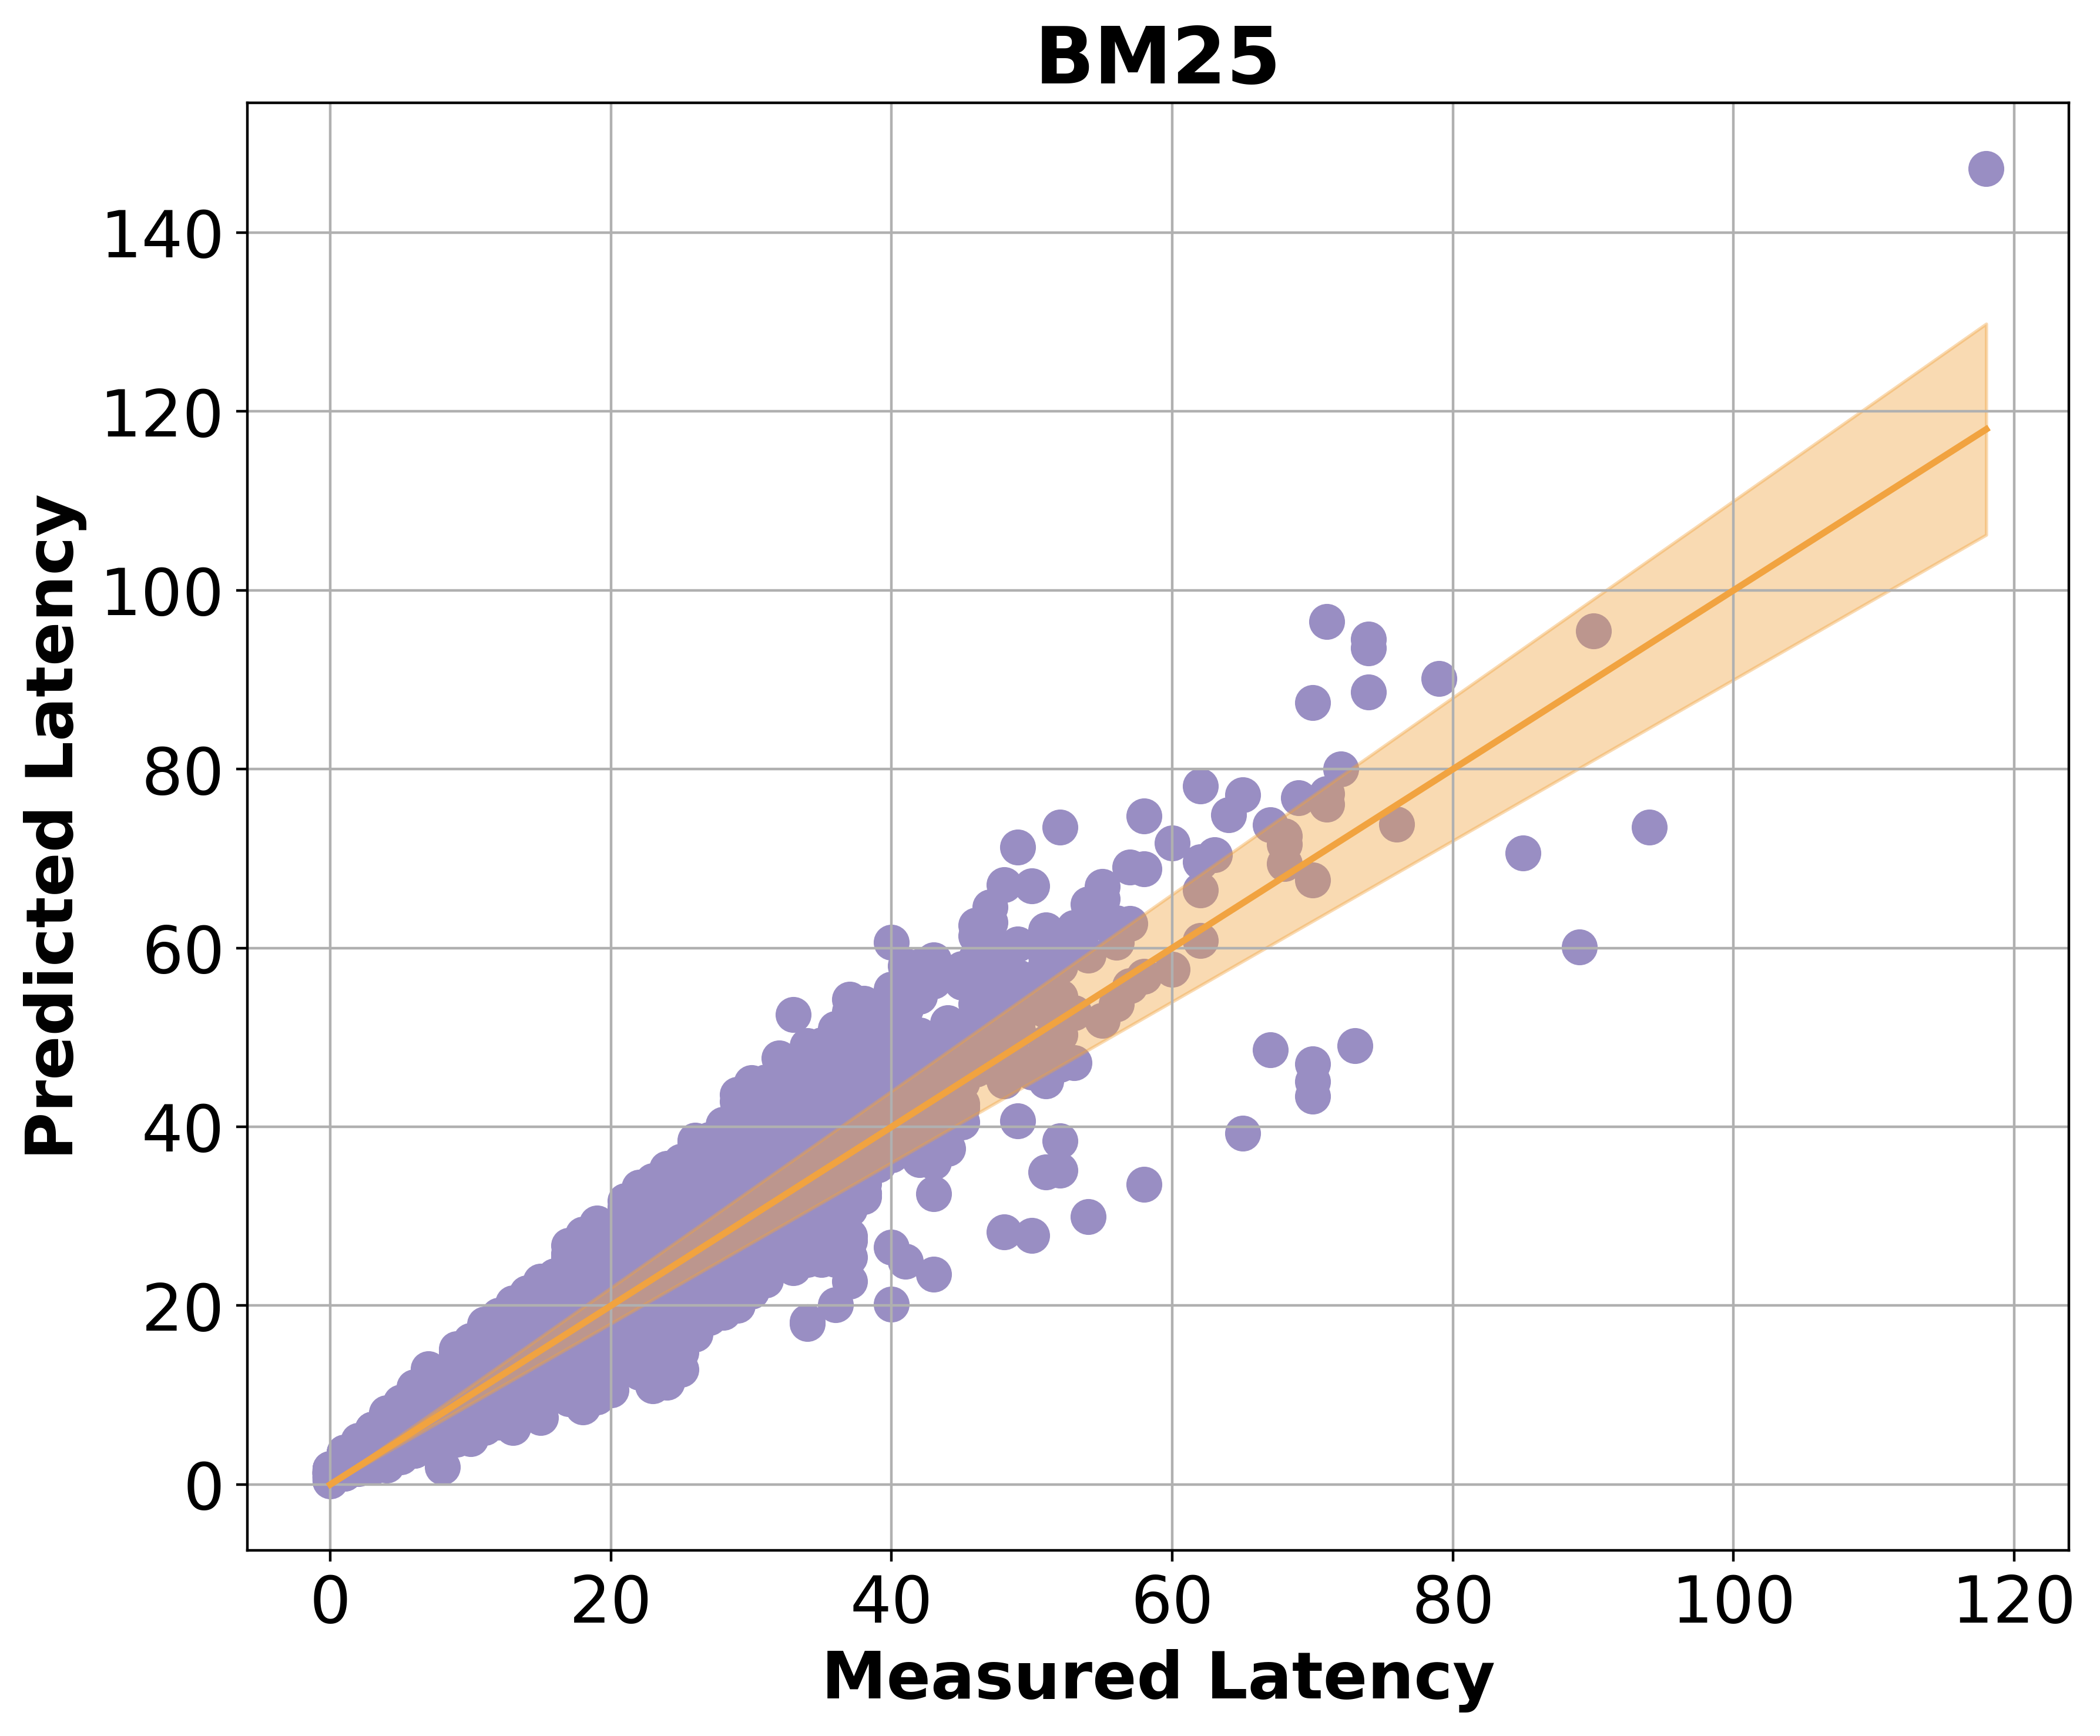

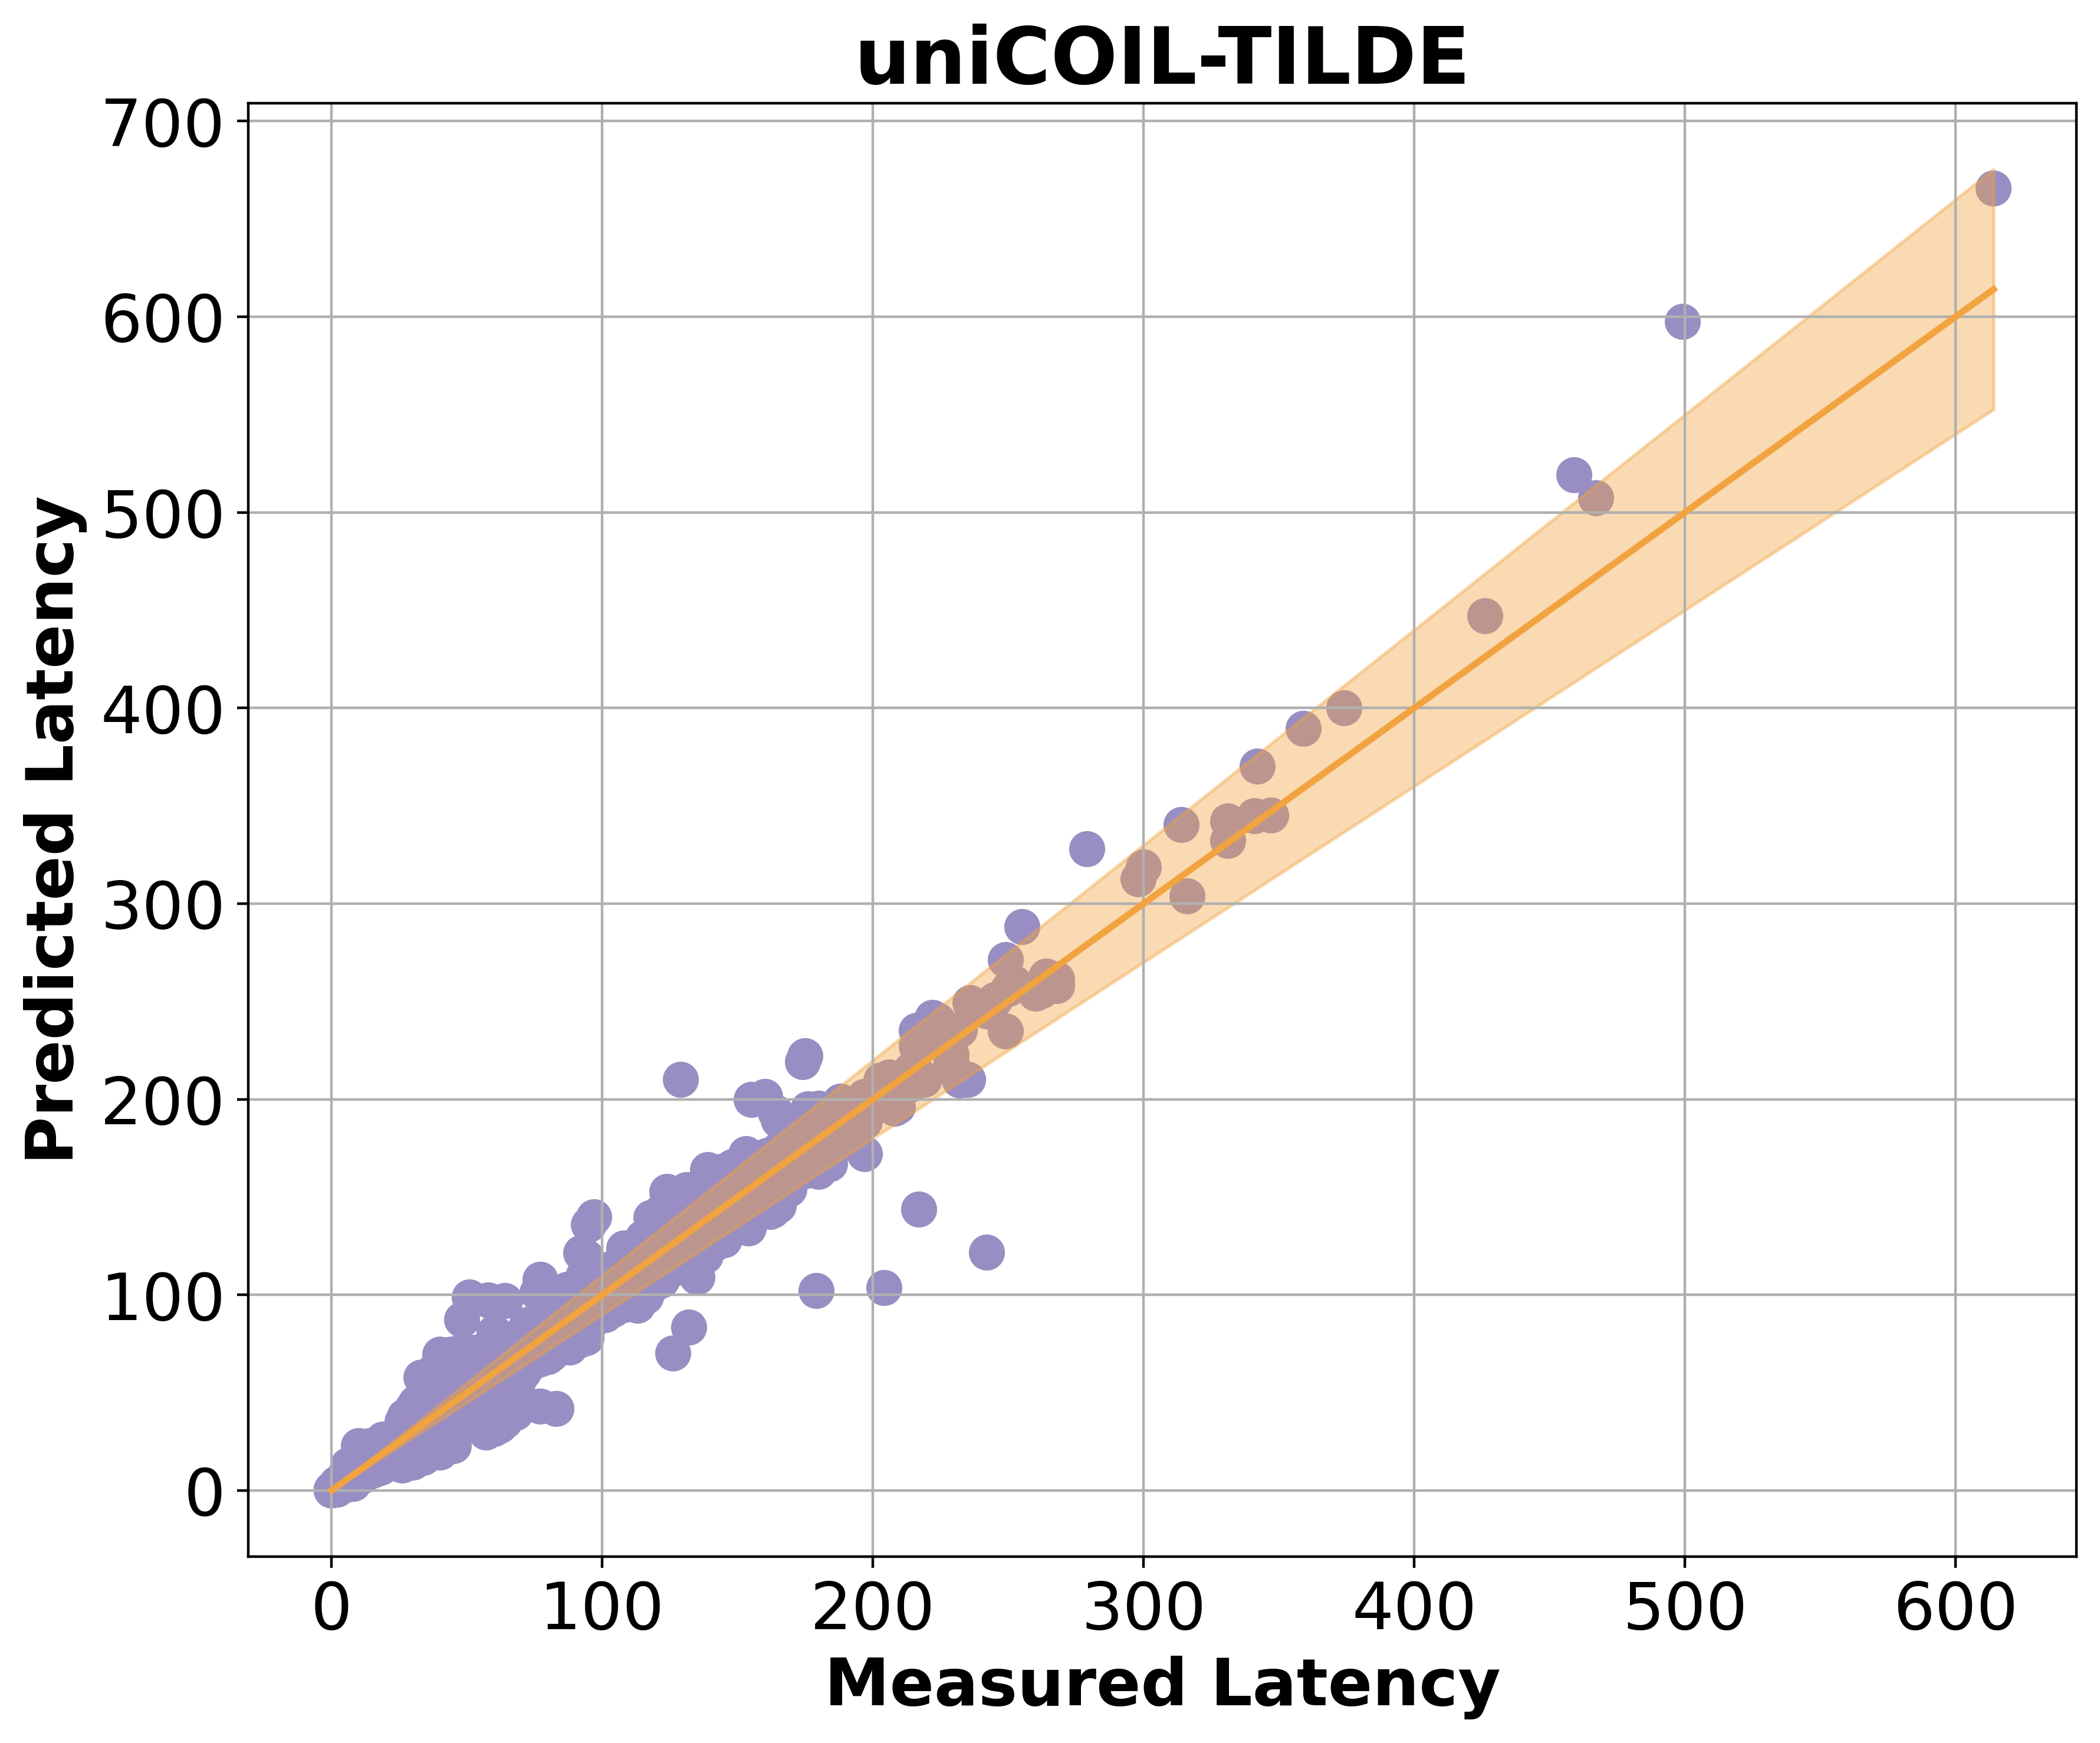

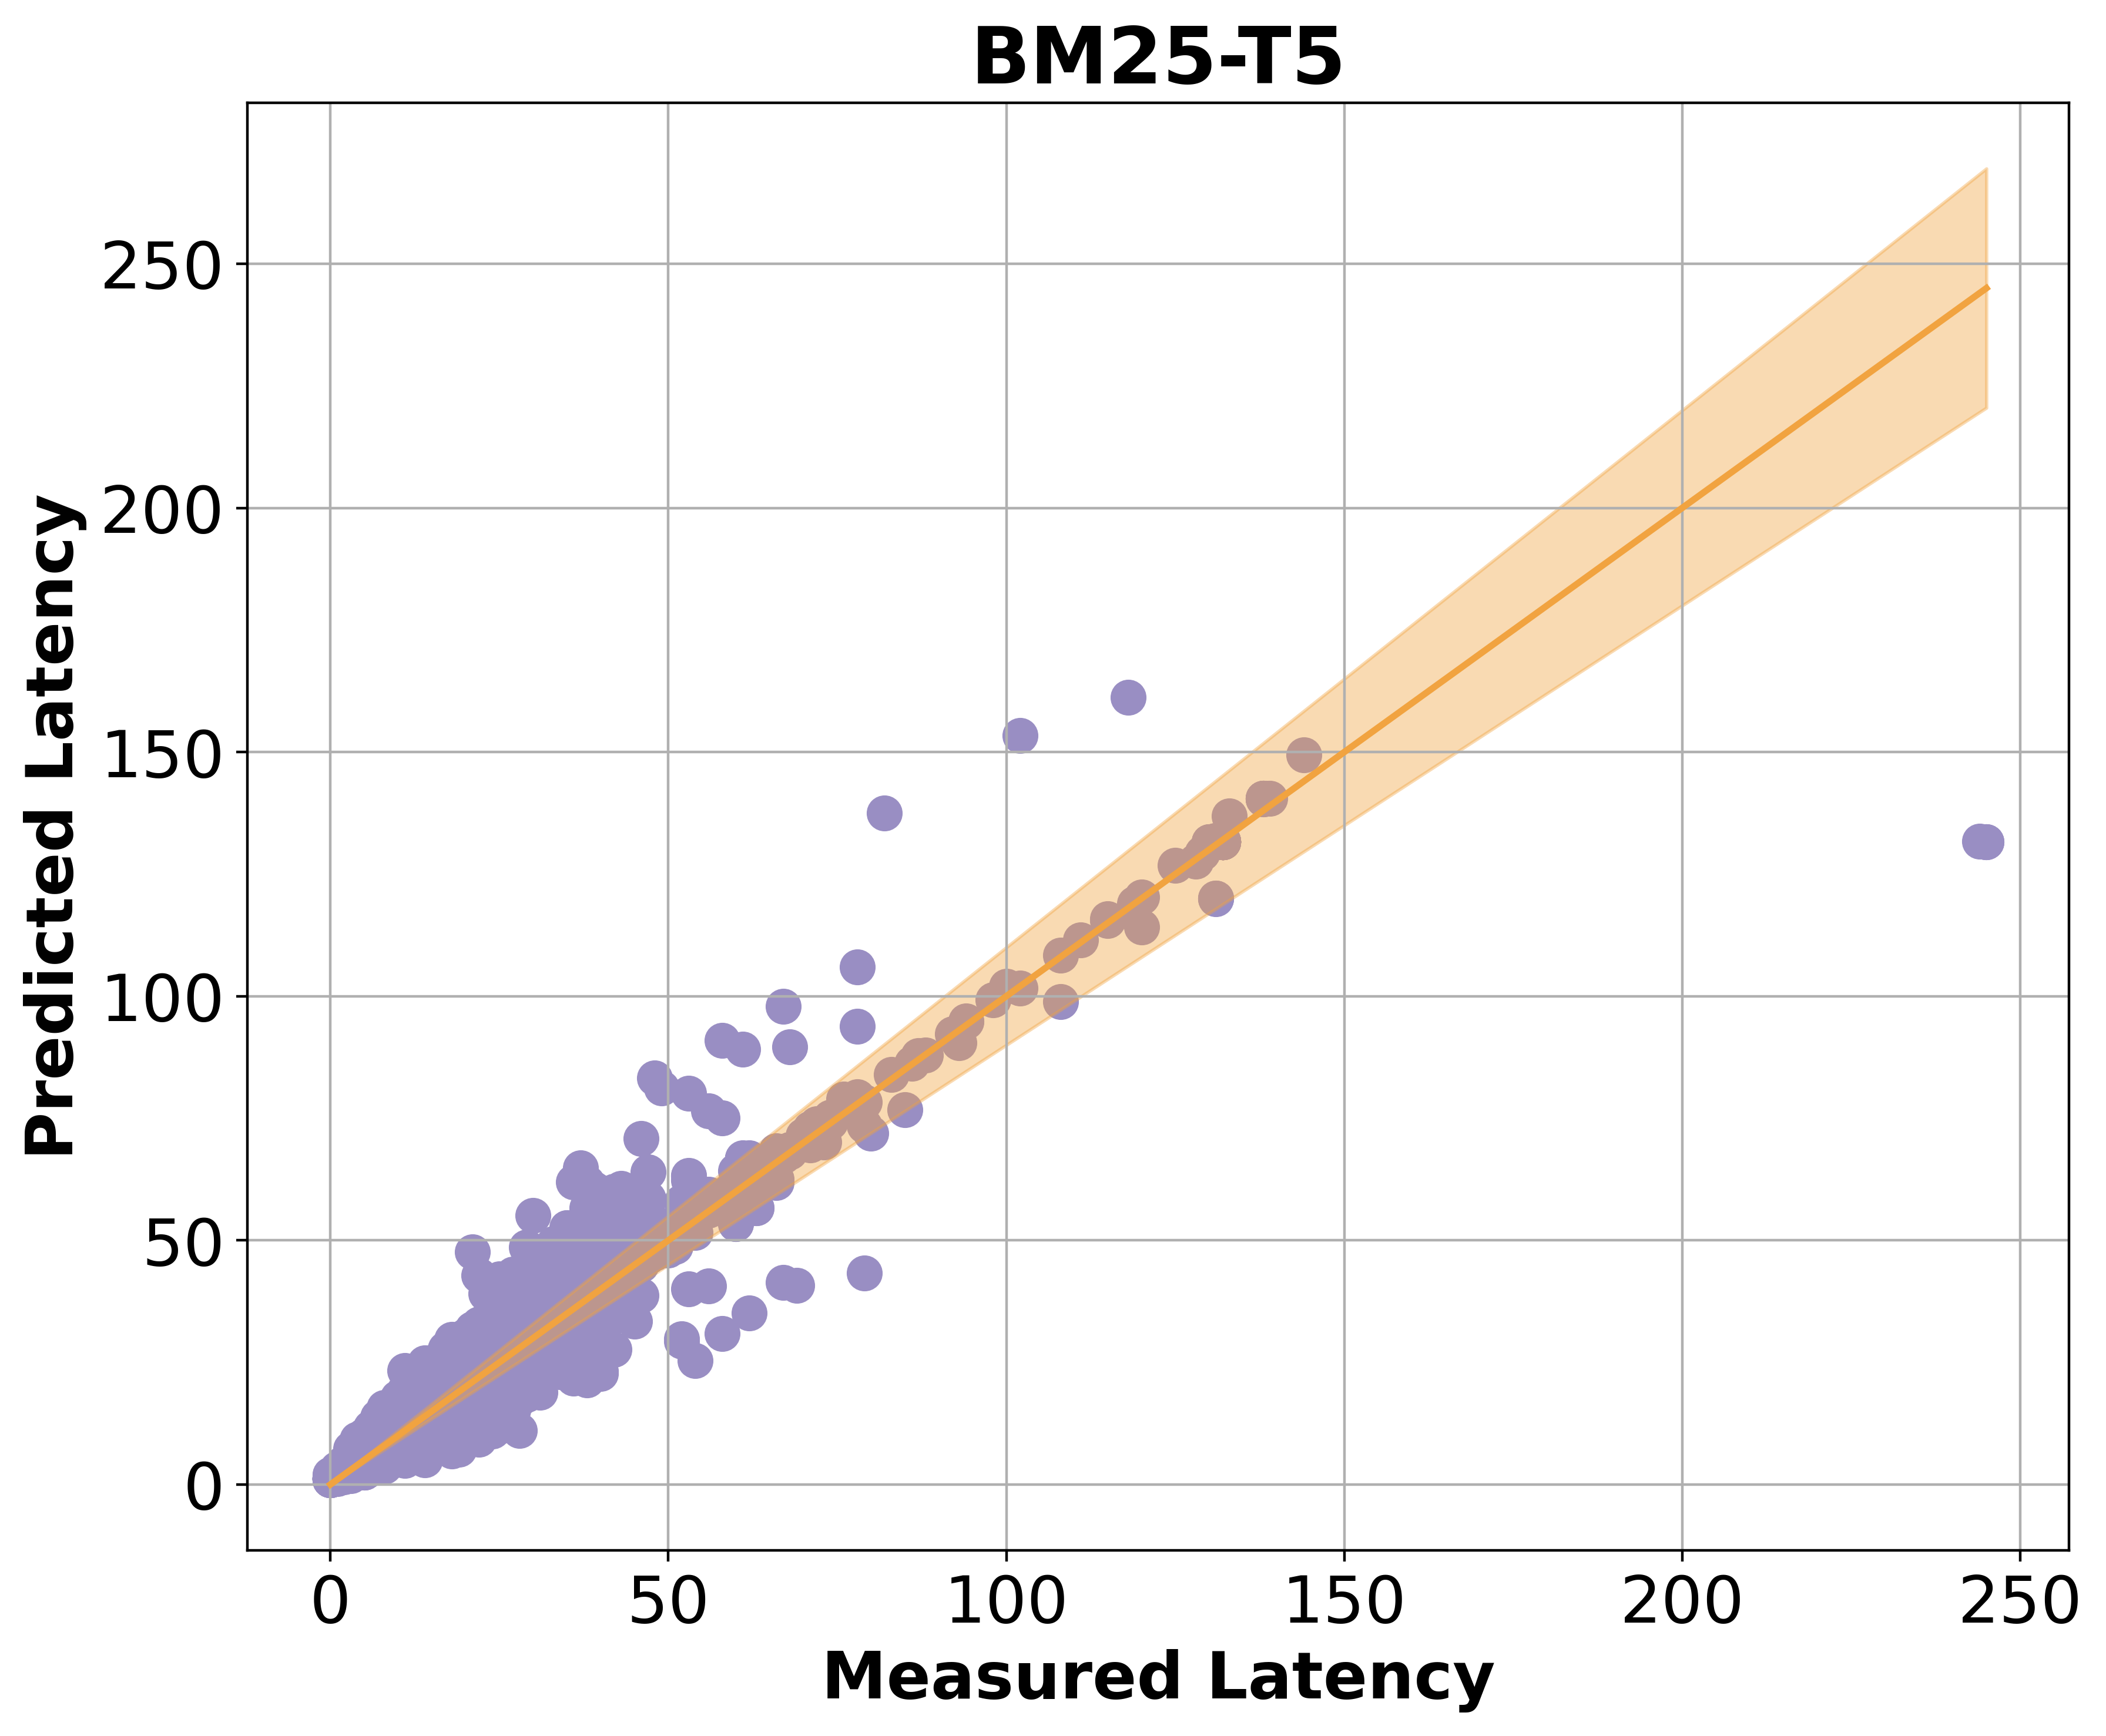

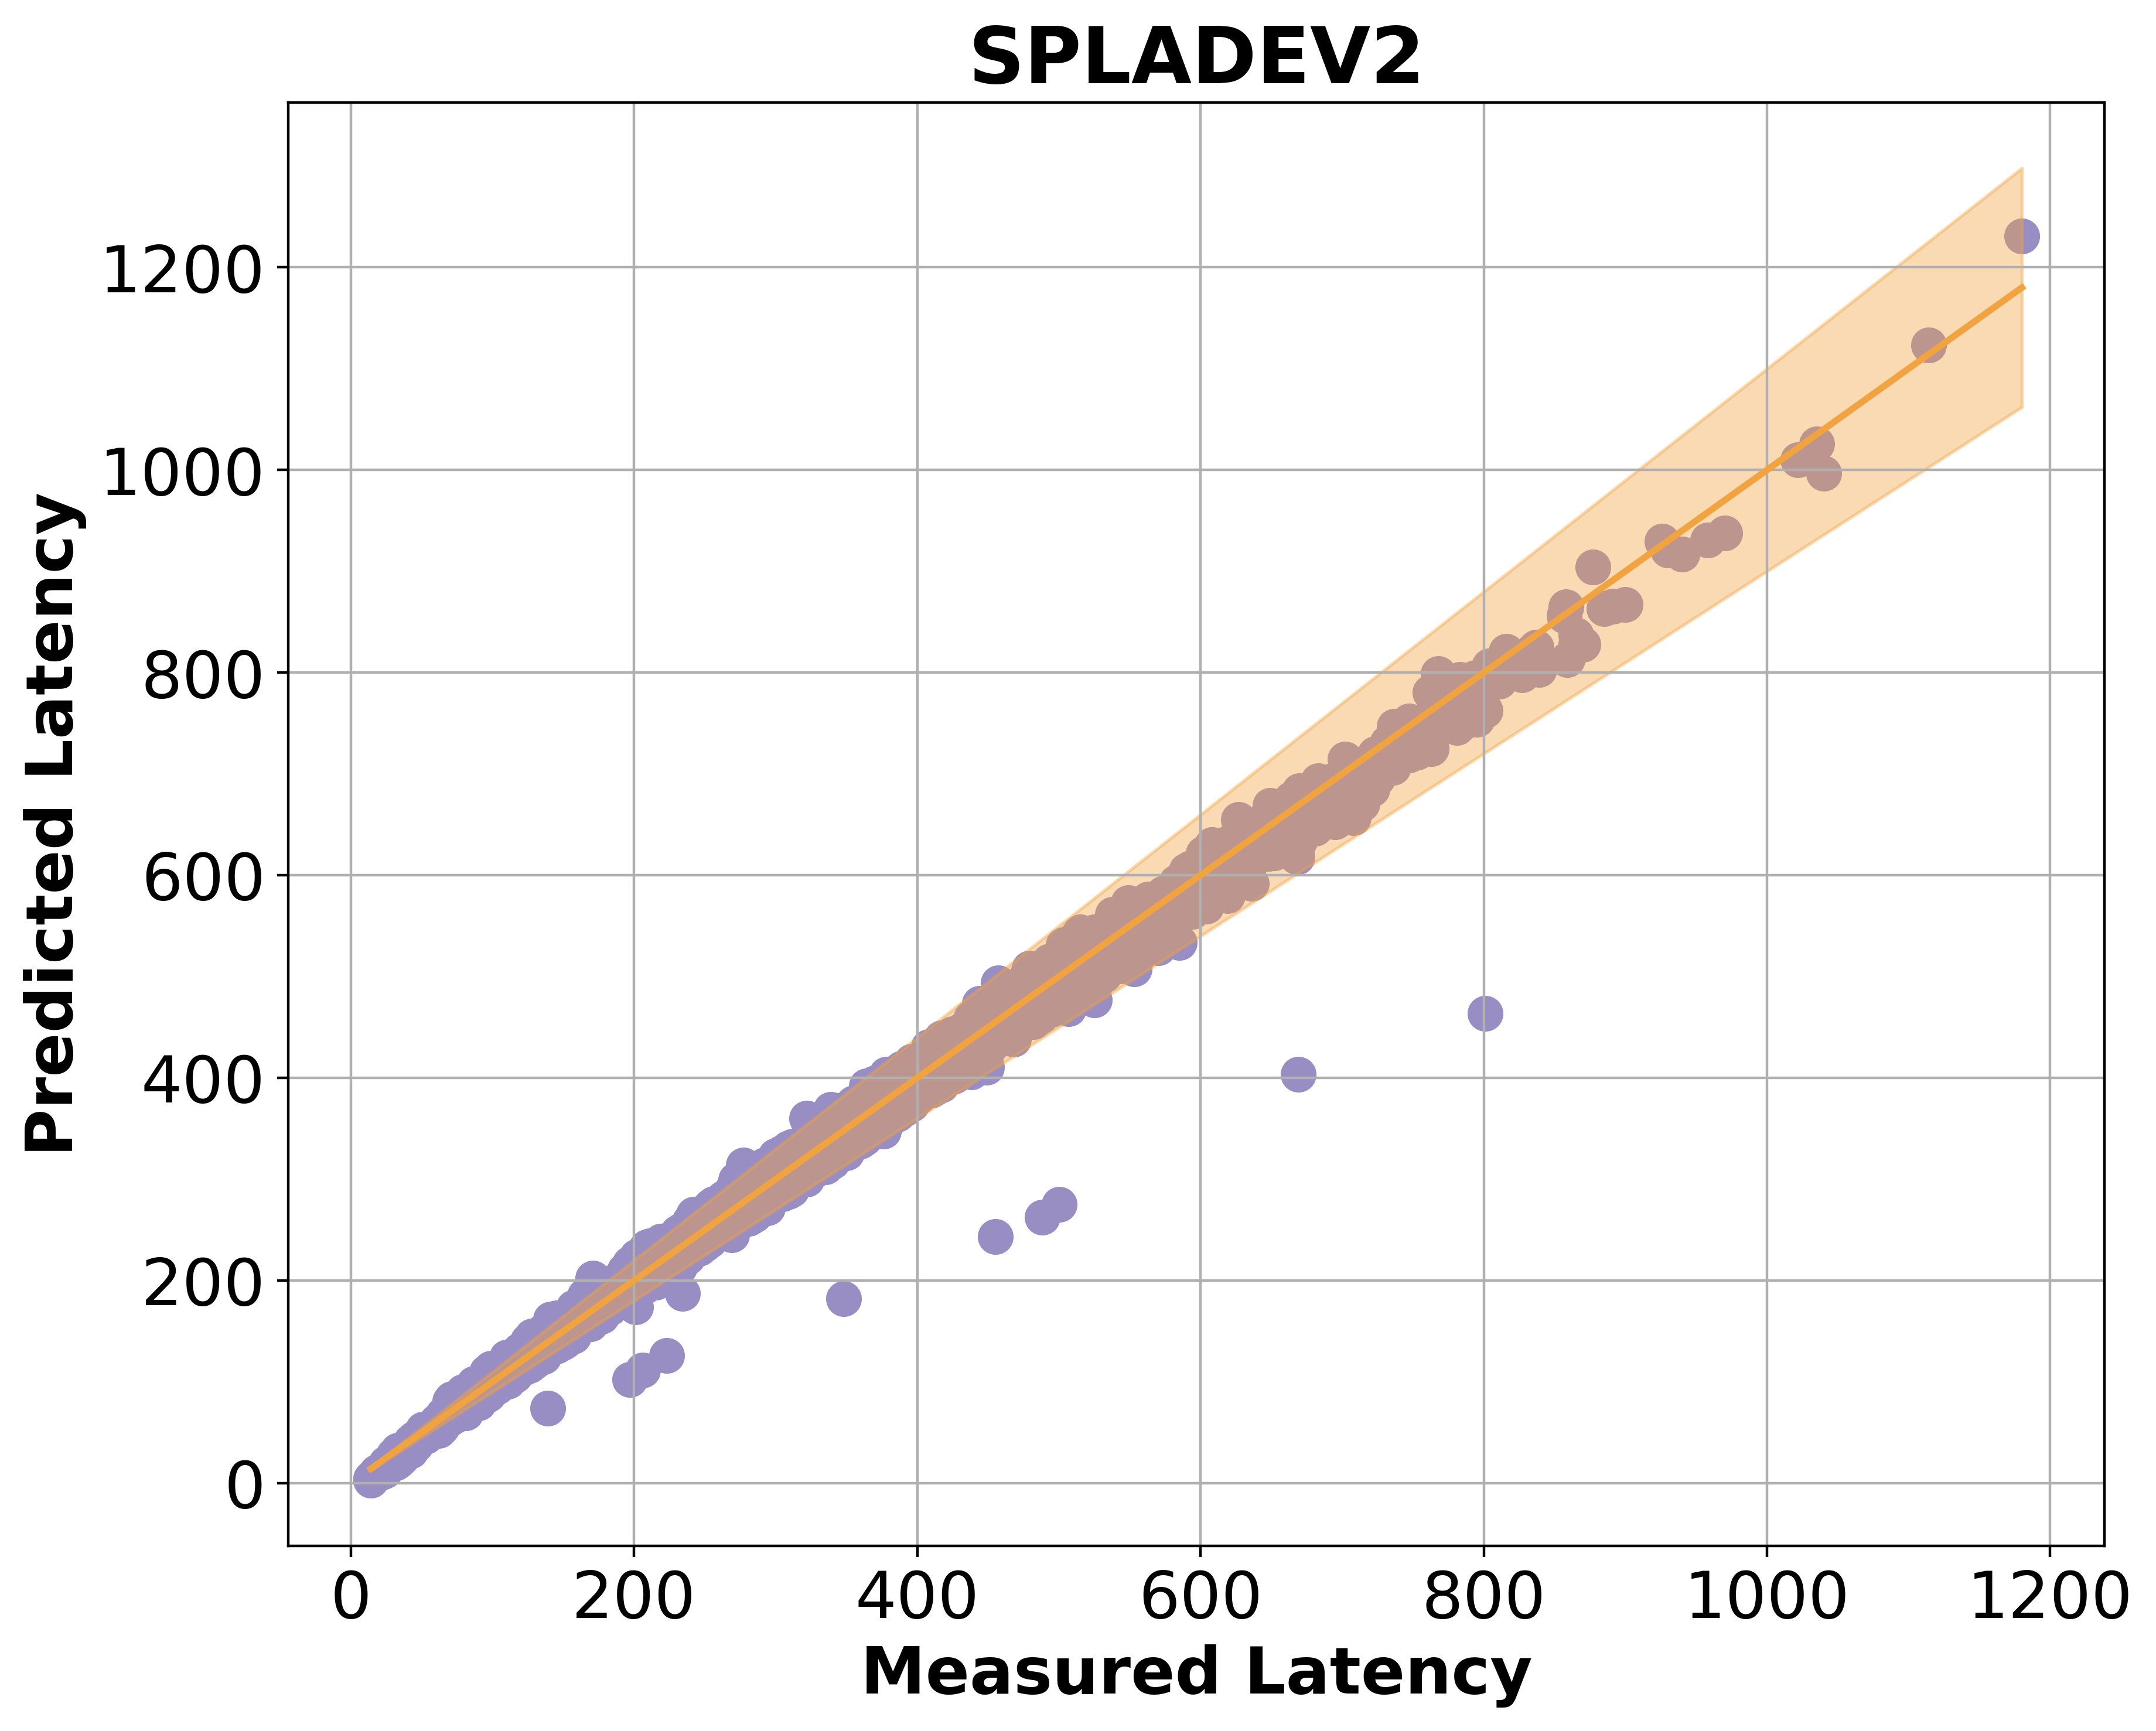

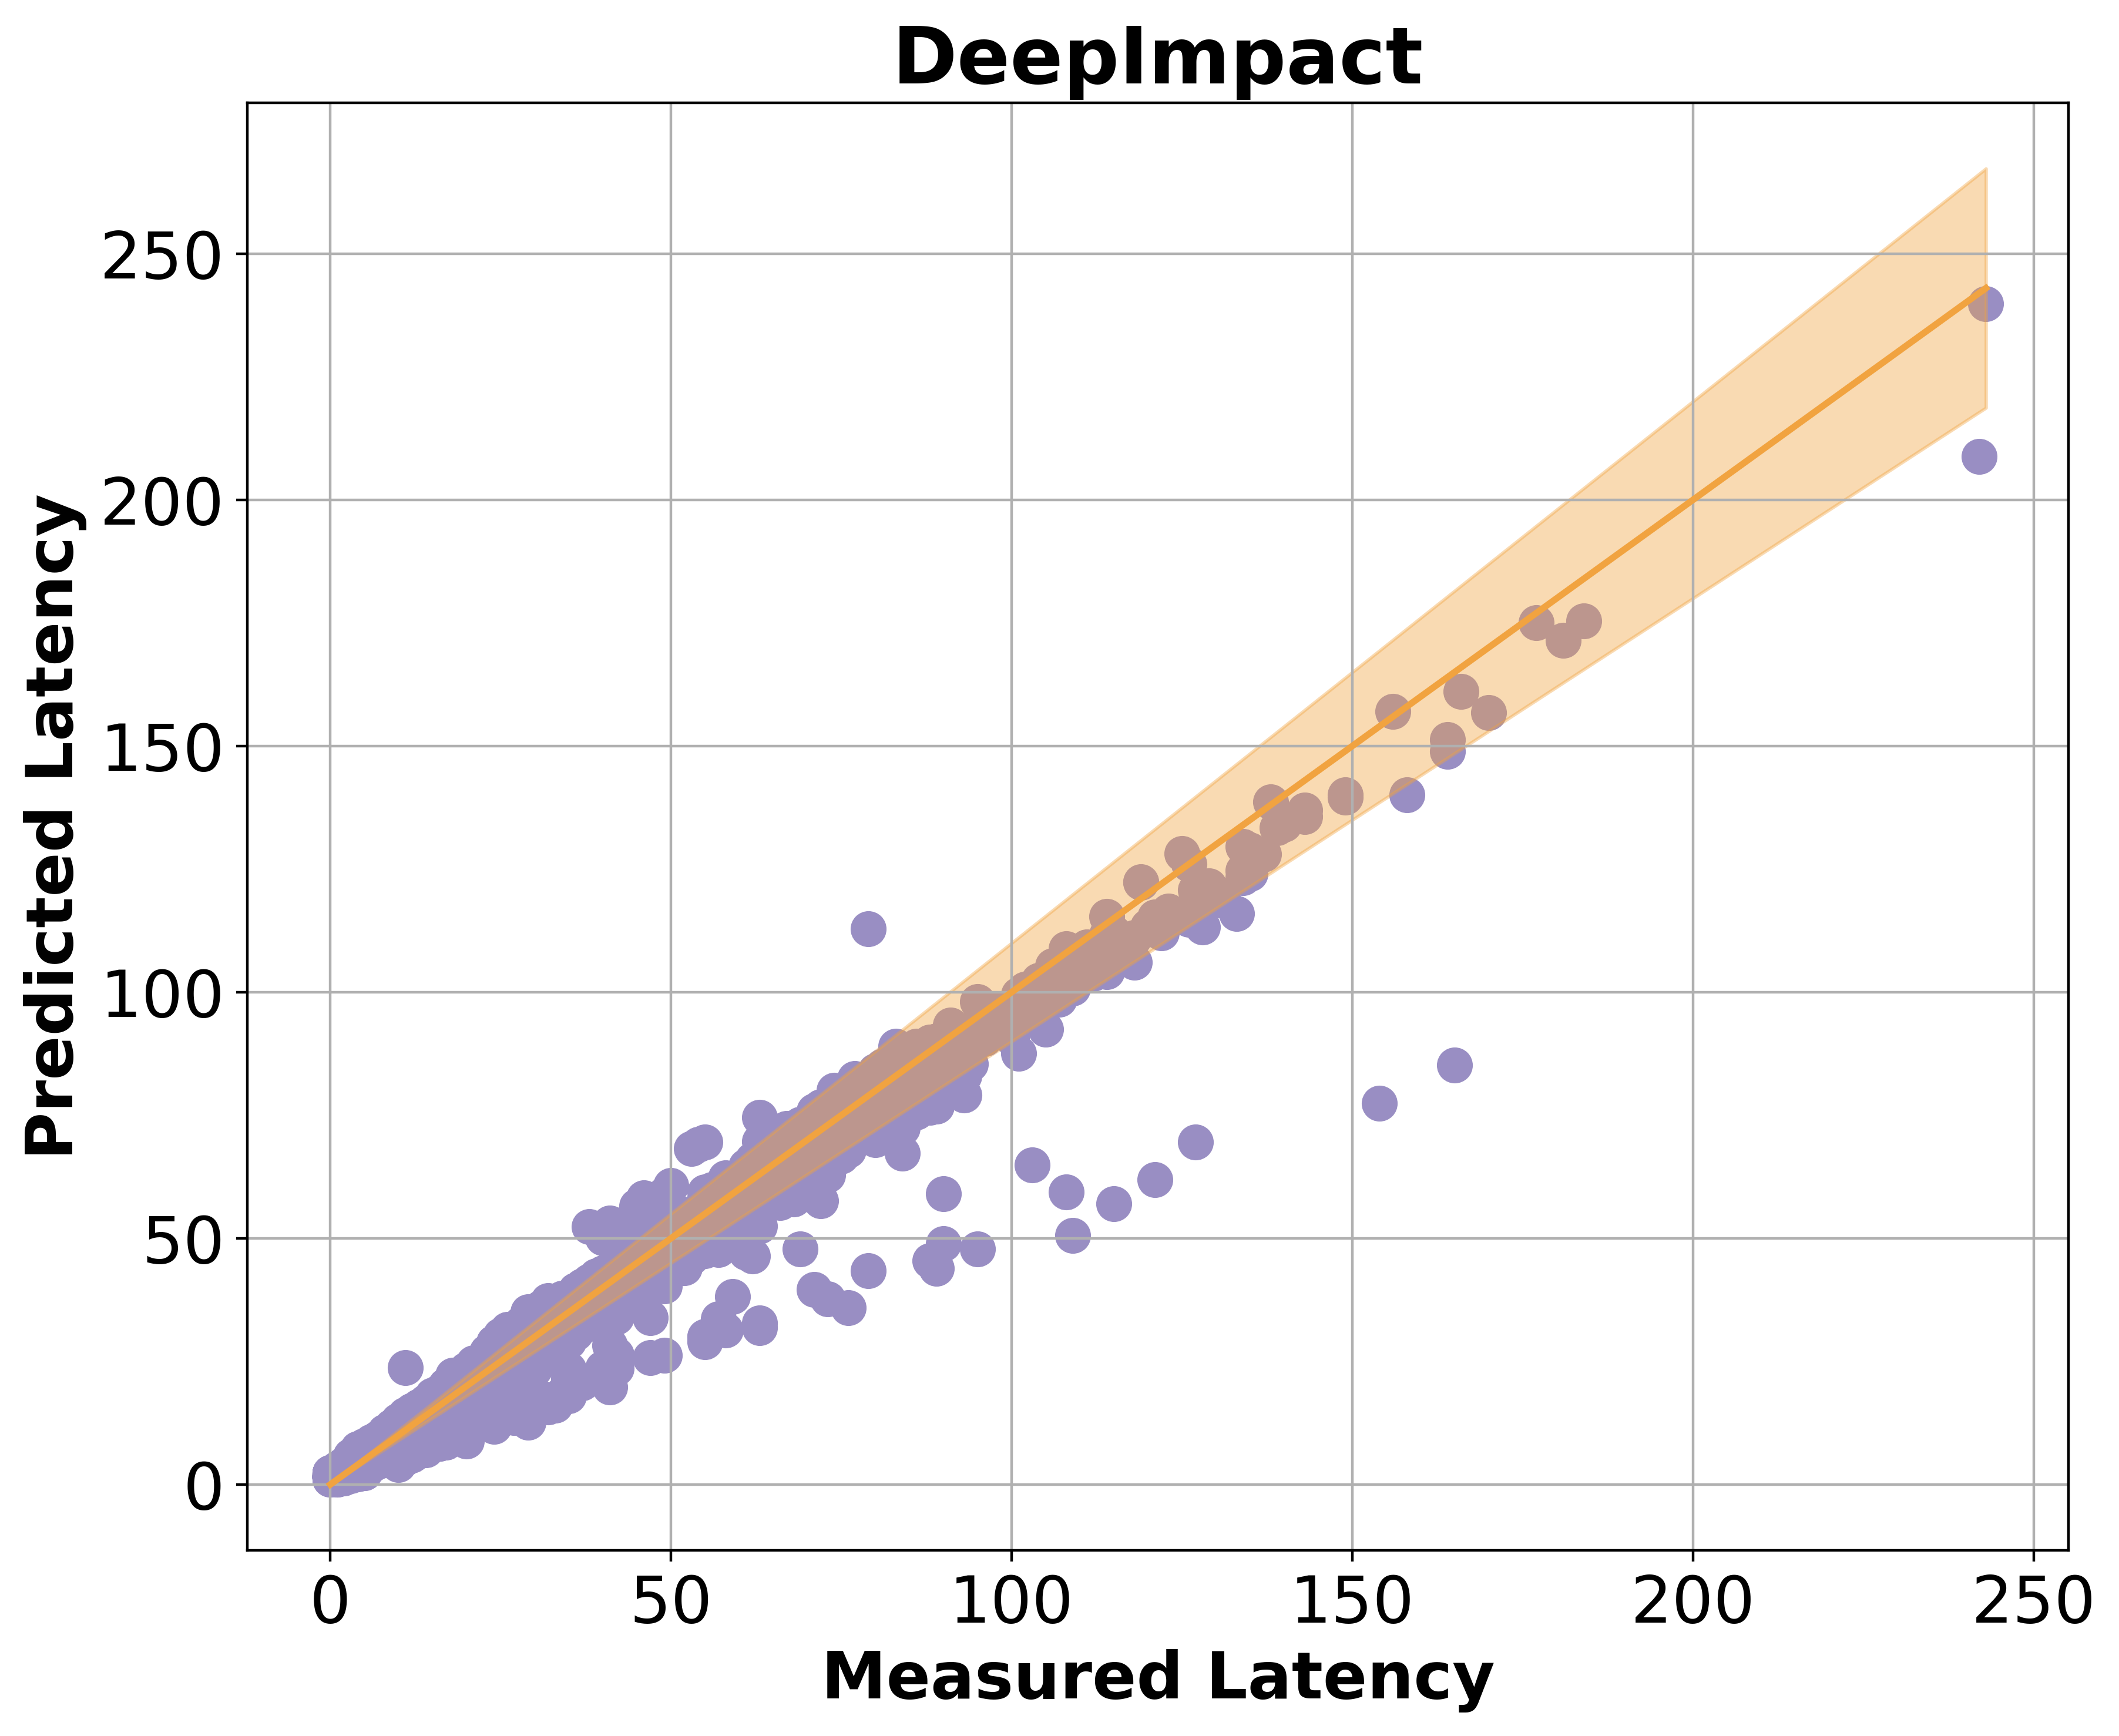

In [9]:
temp_dfs = []
for clus_q, clus in [("cluster == 'irlab'", "irlab"), ("cluster == 'vu'", "vu")]:
    r2_scores_ref_dict = {"index_ref":[], "mop_r2": [], "flop_r2": [], "mopflop_r2": [], "lr_r2": [], }
    for index_ref in set(df["index_ref"]):
        r2_scores_index = plot_rq1(df.query(clus_q), clus, index_ref, ts=0.99, margin=[0.9, 1.1], draw_figs=False)
        r2_scores_ref_dict["index_ref"].append(index_ref)
        r2_scores_ref_dict["mop_r2"].append(r2_scores_index[0][0])
        r2_scores_ref_dict["flop_r2"].append(r2_scores_index[1][0])
        r2_scores_ref_dict["mopflop_r2"].append(r2_scores_index[2][0])
        r2_scores_ref_dict["lr_r2"].append(r2_scores_index[3][0])

    r2_scores_df = pd.DataFrame(r2_scores_ref_dict)
    temp_dfs.append(r2_scores_df)

In [10]:
temp_dfs[1] = temp_dfs[1].drop(columns=["index_ref"])
tp = pd.concat(temp_dfs, axis=1)
tp.round(3)

index_ref  mop_r2  flop_r2  mopflop_r2  lr_r2  mop_r2  flop_r2  \
0     uniCOIL-T5   0.971    0.939       0.985  0.977   0.966    0.941   
1           BM25   0.801   -0.259       0.969  0.990   0.463   -1.076   
2  uniCOIL-TILDE   0.986    0.930       0.985  0.984   0.979    0.930   
3        BM25-T5   0.968    0.367       0.989  0.997   0.742    0.308   
4       SPLADEV2   0.988    0.859       0.990  0.997   0.983    0.856   
5     DeepImpact   0.969    0.469       0.987  0.993   0.957    0.485   

   mopflop_r2  lr_r2  
0       0.981  0.973  
1       0.820  0.884  
2       0.977  0.977  
3       0.950  0.964  
4       0.986  0.994  
5       0.970  0.977

# Evaluation: Sec 6.3

In [11]:
import matplotlib.patches as patches

def plot_rq2(idx: pd.DataFrame):
    idx["mem"] = idx["f1"] + 3 * idx["p1"] + 6 * idx["f2"] + 2 * idx["p3"] + 2 * idx["wcnt"] + 6 * idx["f3"] + idx["p5"] + idx["p6"]


    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=400)

    categories = df['index_ref'].unique()
    # Define the width of the boxplots and the position offset
    width = 0.35  # Width for each boxplot
    positions_A = np.arange(len(categories)) - width / 2  # Shift for Values_A
    positions_B = np.arange(len(categories)) + width / 2  # Shift for Values_B

    compare_columns = df['index_ref'].unique()
    num_columns = len(compare_columns)
    positions_group1 = range(1, num_columns + 1)  # Positions for first group
    positions_group1 = [i*0.5 + x for i,x in enumerate(positions_group1)]
    positions_group2 = [x + 0.35 for x in positions_group1]  # Shift positions for second group
    positions_group3 = [x + 0.7 for x in positions_group1]  # Shift positions for second group

    
    bp1 = idx.query("cluster == 'irlab'").boxplot(by="index_ref", column="while_time", grid=False, ax=ax1, positions=positions_A, widths=0.3, patch_artist=True, boxprops=dict(facecolor="#e66101"), color="black",)
    # ********************
    box_x = -0.14  # x position of the box (negative moves it left of the y-axis)
    box_y = 0.69   # y position of the box (above the y-label)
    box_width = 0.03
    box_height = 0.06

    # Create a base color rectangle (e.g., blue)
    rect = patches.Rectangle((box_x, box_y - box_height / 2), box_width, box_height,
                            linewidth=1, edgecolor='black', facecolor='#e66101',
                            transform=ax1.transAxes, clip_on=False)
    ax1.add_patch(rect)
    # ********************
    ax1.set_ylabel('Miliseconds') # , labelpad=50
    ax1.set_title("")
    ax1.set_label("Latency w. Intel")
    xtick_labels_right_ordered = ax1.get_xticklabels()
    ax2 = ax1.twinx()
    
    bp2 = idx.query("cluster == 'irlab'").boxplot(by="index_ref", column="mem", grid=False, ax=ax2, positions=positions_B, widths=0.3, patch_artist=True, boxprops=dict(facecolor="#5e3c99"), color="black",)
    # ********************
    box_x = 1.04  # x position of the box (negative moves it left of the y-axis)
    box_y = 0.83   # y position of the box (above the y-label)
    box_width = 0.03
    box_height = 0.06

    # Create a base color rectangle (e.g., blue)
    rect = patches.Rectangle((box_x, box_y - box_height / 2), box_width, box_height,
                            linewidth=1, edgecolor='black', facecolor='#5e3c99',
                            transform=ax2.transAxes, clip_on=False)
    ax2.add_patch(rect)

    # ********************
    ax2.set_ylabel('Number of Operations')
    ax2.set_title("")
    # ax2.legend(["Mop"])
    ax2.set_label("Mop")

    ax1.set_xticks(np.arange(len(categories)))
    ax1.set_xticklabels(xtick_labels_right_ordered, rotation=45, ha='right')
    ax1.set_xlabel("Retrieval Methods")

    fig.suptitle("")

    # Create a custom legend for both axes
    legend_A = plt.Line2D([0], [0], color='#e66101', lw=4, label='Latency w. Intel')
    legend_B = plt.Line2D([0], [0], color='#5e3c99', lw=4, label='Mop')

    # Combine legends from both axes
    ax1.legend(handles=[legend_A, legend_B], loc='upper left',  prop={'weight':'bold'})

    plt.savefig("figures/rq2.pdf", bbox_inches='tight')


    # ################
    result_latency_intel = idx.query("cluster == 'irlab'").groupby('index_ref')['while_time'].agg(
        LatencyINTEL='mean',
    )
    result_latency_intel["LatencyINTEL/BM25"] = result_latency_intel["LatencyINTEL"]/ result_latency_intel["LatencyINTEL"]["BM25"].item()

    result_latency_amd = idx.query("cluster == 'vu'").groupby('index_ref')['while_time'].agg(
        LatencyAMD='mean',
    )
    result_latency_amd["LatencyAMD/BM25"] = result_latency_amd["LatencyAMD"]/ result_latency_amd["LatencyAMD"]["BM25"].item()

    result_operations = idx.query("cluster == 'irlab'").groupby('index_ref')['mem'].agg(
        TotalMop='sum',
        Mop='mean',
    )
    result_operations["Mop/BM25"] = result_operations["Mop"]/ result_operations["Mop"]["BM25"].item()

    return pd.concat([result_latency_amd, result_latency_intel, result_operations], axis=1)

LatencyAMD  LatencyINTEL           Mop  LatencyAMD/BM25  \
index_ref                                                                
BM25                13.90         12.26  5.411608e+06             1.00   
BM25-T5             17.15         18.32  7.324214e+06             1.23   
DeepImpact          24.50         26.37  1.797214e+07             1.76   
SPLADEV2           277.97        290.97  1.618180e+08            20.00   
uniCOIL-T5          48.92         50.69  3.247726e+07             3.52   
uniCOIL-TILDE       40.88         41.32  2.654655e+07             2.94   

               LatencyINTEL/BM25  Mop/BM25  
index_ref                                   
BM25                        1.00      1.00  
BM25-T5                     1.49      1.35  
DeepImpact                  2.15      3.32  
SPLADEV2                   23.74     29.90  
uniCOIL-T5                  4.13      6.00  
uniCOIL-TILDE               3.37      4.91

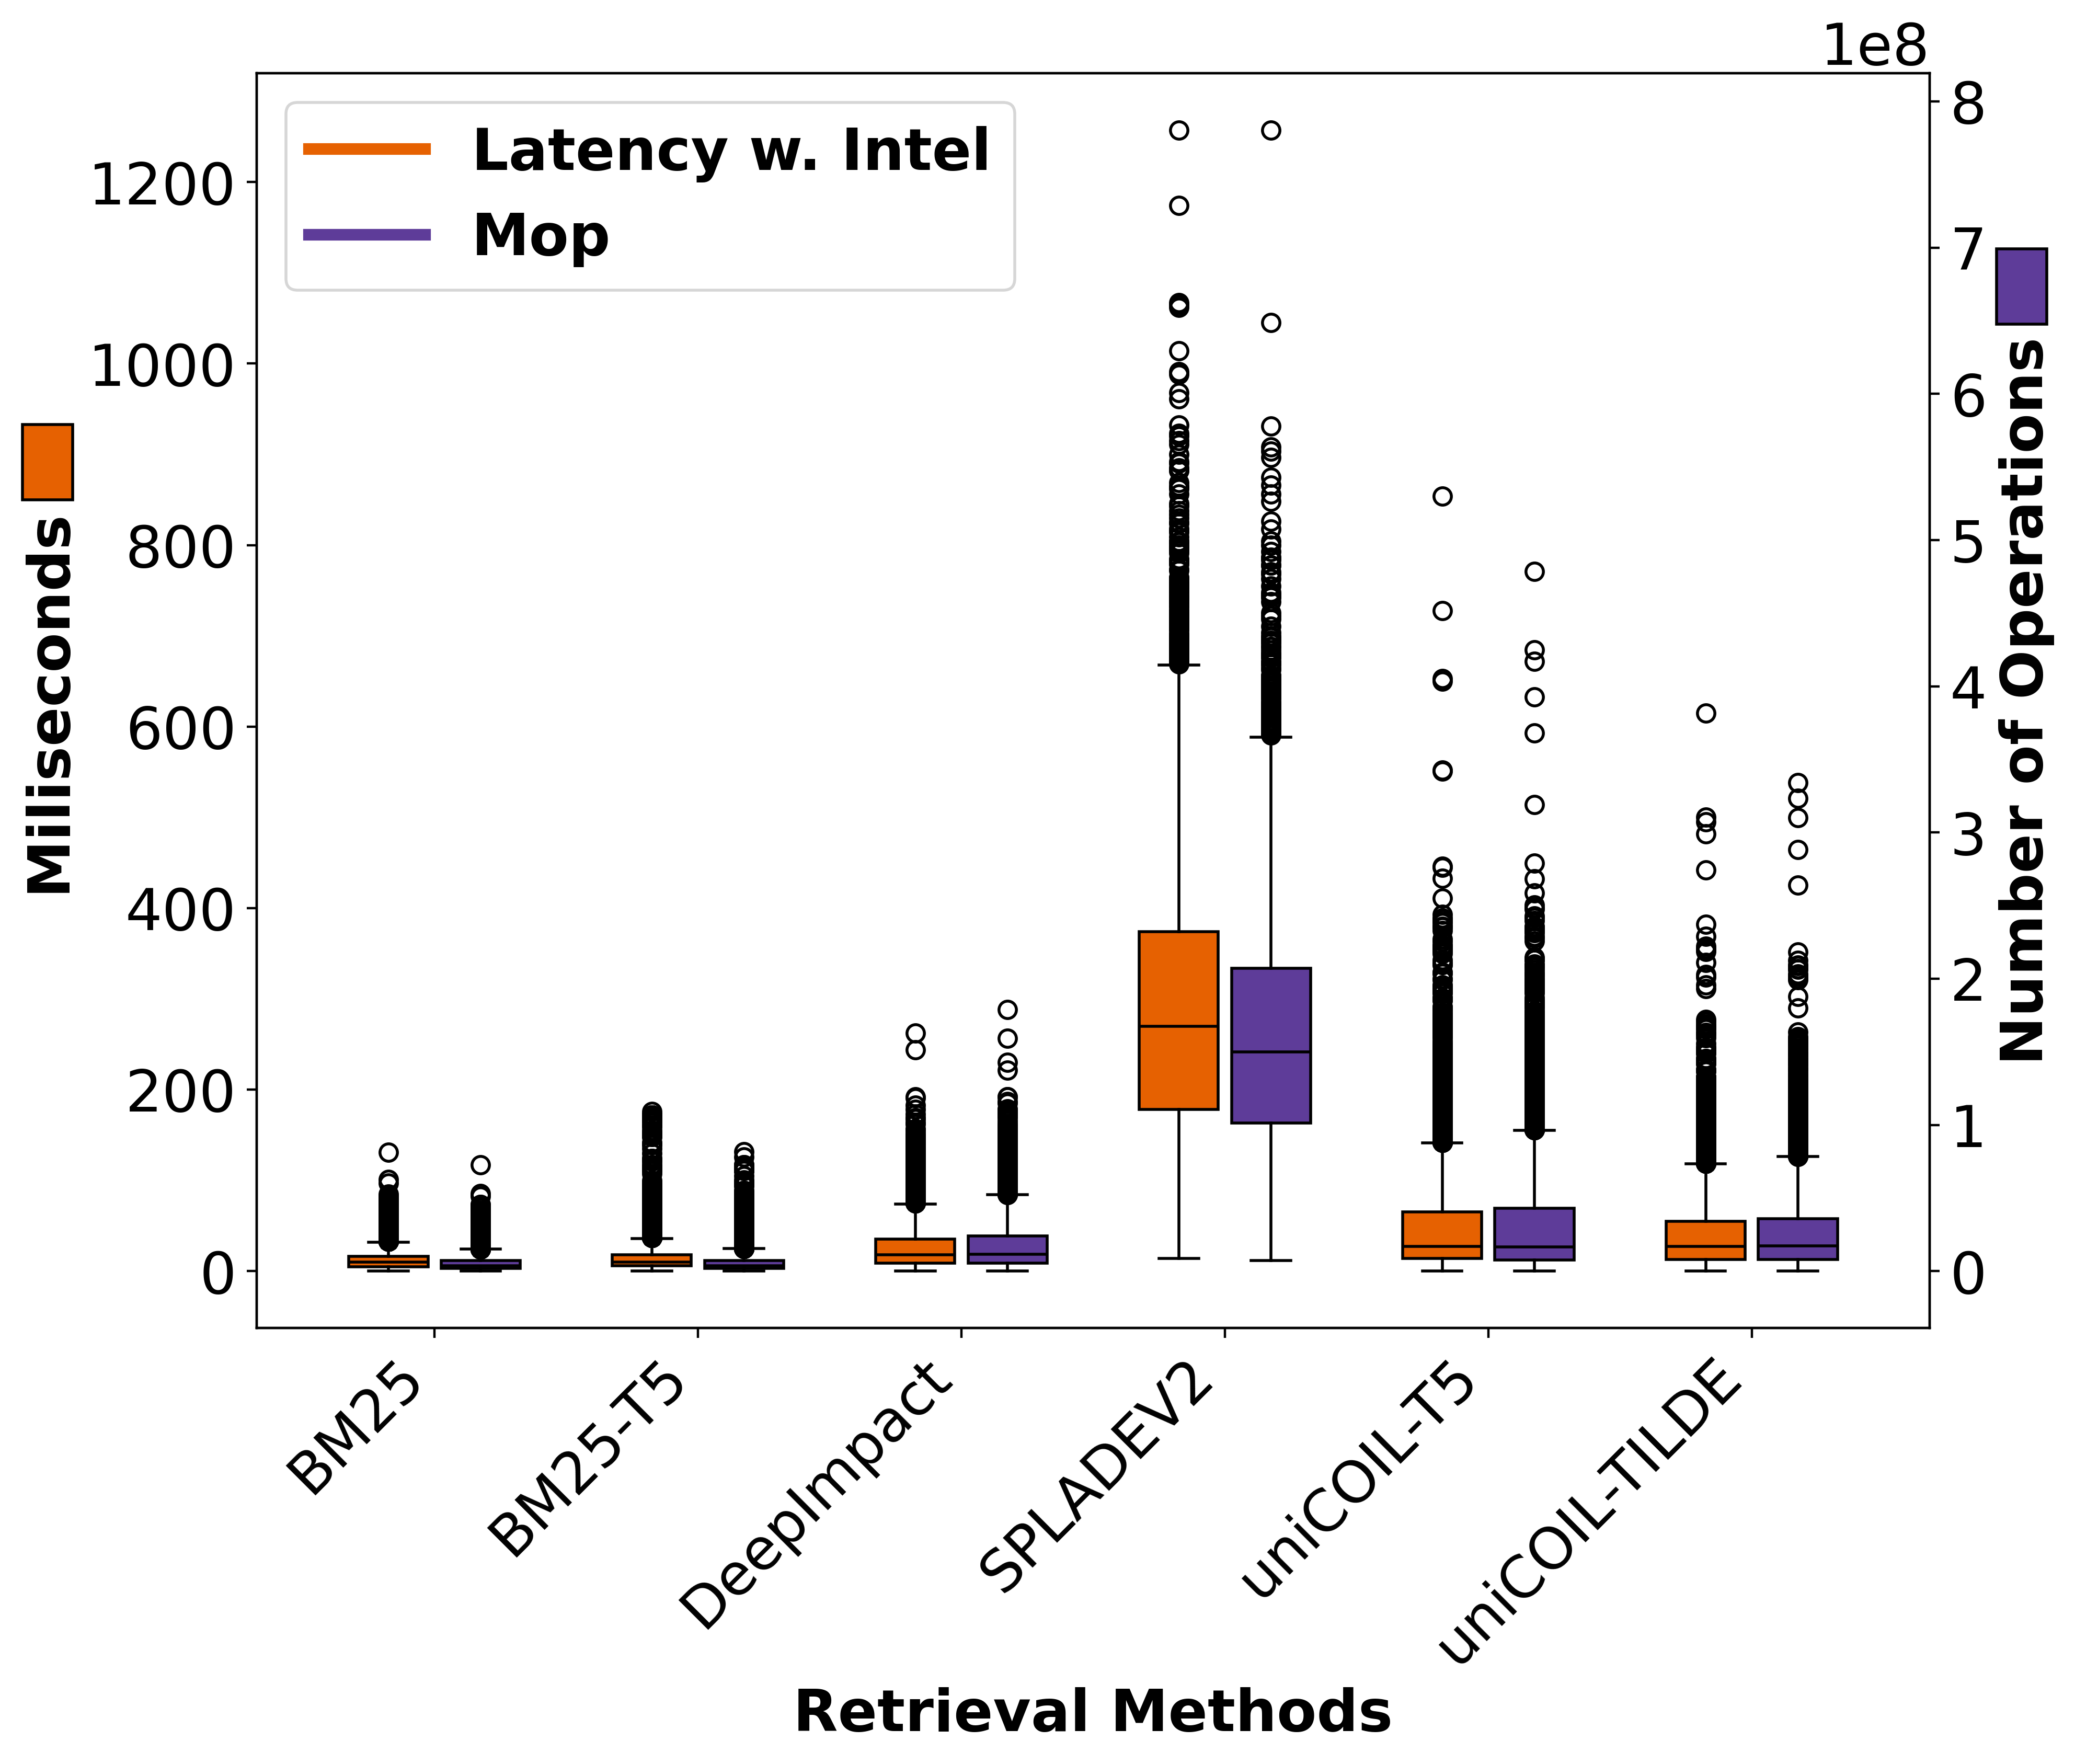

In [12]:
result = plot_rq2(df)
result = result[["LatencyAMD", "LatencyINTEL", "Mop", "LatencyAMD/BM25", "LatencyINTEL/BM25", "Mop/BM25"]]
result.round(2)

# Evaluation: Sec 6.4

In [13]:
def plot_rq3(idx):

    all_of_indexes = df['index_ref'].unique()
    fig, axs = plt.subplots(1, 1, figsize=(10, 8), dpi=400)
    
    compare_columns = ["f1", "f2", "f3"]
    num_columns = len(compare_columns)
    positions_group1 = range(1, num_columns + 1)  # Positions for first group
    positions_group1 = [i*0.5 + x for i,x in enumerate(positions_group1)]
    positions_group2 = [x + 0.35 for x in positions_group1]  # Shift positions for second group
    positions_group3 = [x + 0.7 for x in positions_group1]  # Shift positions for second group

    scaler = MinMaxScaler()
    
    # Apply scaling only to the selected columns
    idx_normalized = idx.copy()
    idx_normalized[counter_coeffs] = scaler.fit_transform(idx[counter_coeffs])

    idx_normalized["termcnt"] = idx["termcnt"]


    idx_normalized.boxplot(ax=axs, column=compare_columns, positions=positions_group1, widths=0.3, patch_artist=True, 
                                boxprops=dict(facecolor="#e66101"), color="black")

    idx_normalized.sample(frac=0.1).boxplot(ax=axs, column=compare_columns, positions=positions_group2, widths=0.3, patch_artist=True, 
                                boxprops=dict(facecolor="#fdb863"), color="black")

    # Set custom x-tick labels to reflect the queries
    axs.set_xticks([x + 0.5 for x in positions_group1]) 
    axs.set_xticklabels([c.upper() for c in compare_columns])  # Rotate for better readability
    # Set labels and title
    axs.set_xlabel('Coefficients')
    axs.set_ylabel('Count of Coefficients')
    # Create a custom legend for both axes
    legend_A = plt.Line2D([0], [0], color='#e66101', lw=4, label='Complete data')
    legend_B = plt.Line2D([0], [0], color='#fdb863', lw=4, label='10% Sampled')
    axs.legend(handles=[legend_A, legend_B], loc='upper left',  prop={'weight':'bold'})
    # Display the plot
    plt.tight_layout()
    plt.savefig("figures/rq3.pdf",  bbox_inches='tight')
    plt.show()

    


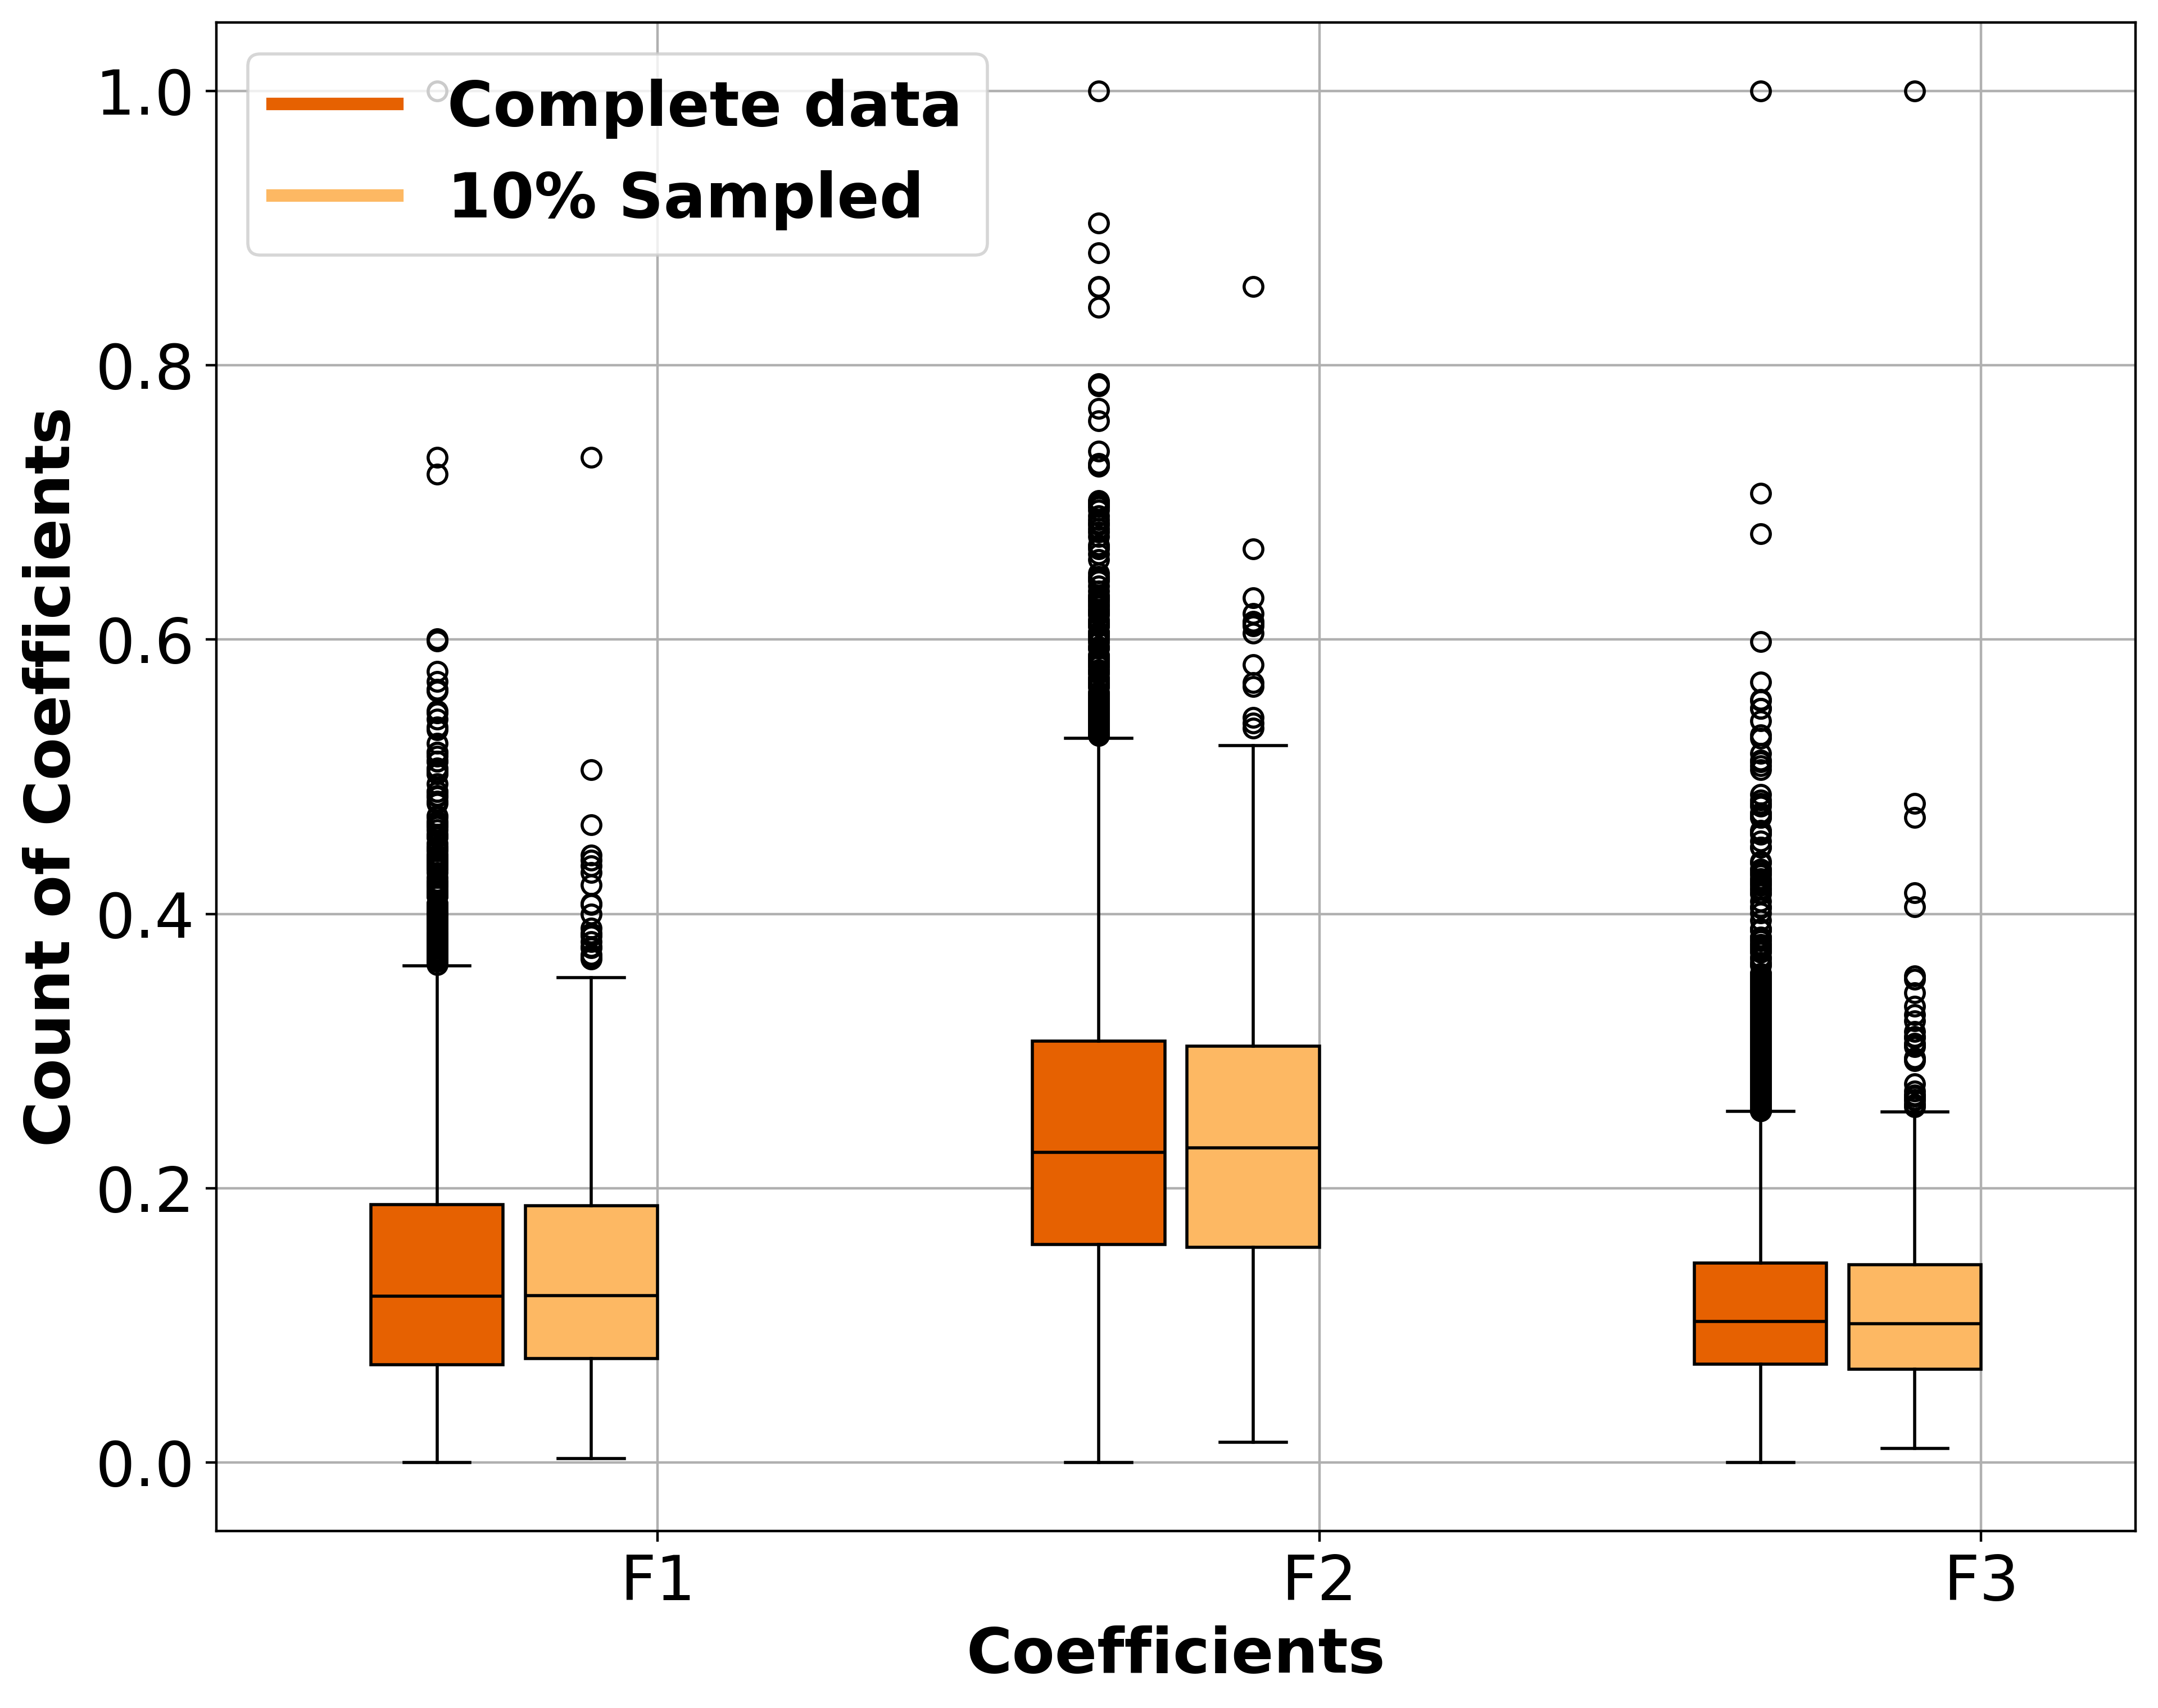

In [14]:
plot_rq3(df.query("index_ref == 'SPLADEV2' and cluster == 'irlab'"))
